# Algorithm Selection

@roman

21 July, 2024

In [158]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import shap
import h3

from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.stats import hmean
from INEGIpy import MarcoGeoestadistico

In [2]:
# Settings
# show 100 columns in pandas
pd.set_option('display.max_columns', 500)
TODAY = pd.to_datetime('today')
# inegi class
inegi_api = MarcoGeoestadistico()

---
# Data

## Mexico Shape

<Axes: >

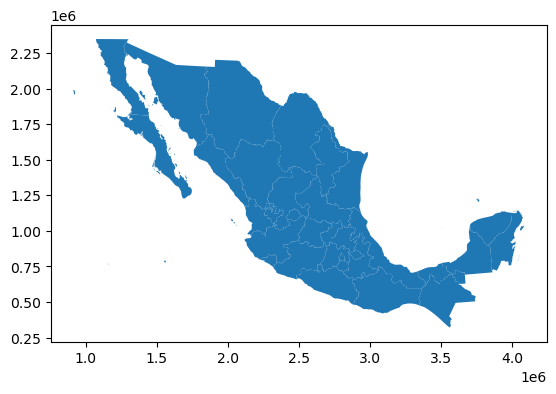

In [3]:
# read country shape
gdf_mexico = inegi_api.Entidades()

# change crs to 6372
gdf_mexico = gdf_mexico.to_crs(epsg=6372)
gdf_mexico.plot()

## Read

In [101]:
def get_properties_data(file_path, cols_to_stay, cols_as_categories):
    # Read database
    df = pd.read_parquet(file_path)

    # Set property_id as index
    df = df.set_index('property_id')

    # Handling NaNs
    df['elevador'] = df['elevador'].fillna(0)
    df['cve_vigilancia'] = df['cve_vigilancia'].fillna(0)
    df['tipo_vialidad'] = df['tipo_vialidad'].fillna(0)

    # Fill missing competitors values with terrain values
    df['competitors_weighted_mean_log_price_per_sqm'] = df['competitors_weighted_mean_log_price_per_sqm'].combine_first(df['mean_log_valor_fisico_terreno_m2'])
    df['competitors_weighted_mean_log_price_per_sqm_lower'] = df['competitors_weighted_mean_log_price_per_sqm_lower'].combine_first(df['mean_log_valor_fisico_terreno_m2_lower'])
    df['competitors_weighted_mean_log_price_per_sqm_upper'] = df['competitors_weighted_mean_log_price_per_sqm_upper'].combine_first(df['mean_log_valor_fisico_terreno_m2_upper'])

    # Casting integer columns
    columns_to_integer = ['cve_vigilancia', 'tipo_vialidad']
    df[columns_to_integer] = df[columns_to_integer].astype('float').round().astype('Int64')

    # Feature Engineering
    first_date_obs = df['valuation_date'].min()
    last_date_obs = df['valuation_date'].max()

    df = (
        df
        .assign(
            year_appraised=lambda x: x['valuation_date'].dt.year,
            price_per_sqm=lambda x: x['valor_mercado'] / x['superficie_vendible'],
            quarters_since_first_appraisal=lambda x: (x['valuation_date'] - first_date_obs).dt.days / (30.4 * 3),
            conservacion_recat=lambda x: x['conservacion'].replace({7: 3.5}) - x['conservacion'].min(),
            cve_vigilancia_recat=lambda x: np.where(x['cve_vigilancia'].eq(2), 1, 0),
            superficie_terreno_usable=lambda x: np.where(
                x['id_tipo_inmueble'].eq(4),
                x['superficie_accesoria'],
                x['superficie_terreno'] + x['superficie_accesoria']
            ),
            elevador=lambda x: x['elevador'].eq(1).astype('int'),
            log_superficie_vendible=lambda x: np.log(x['superficie_vendible']),
            log_superficie_terreno=lambda x: np.log(x['superficie_terreno']),
            log_superficie_construida=lambda x: np.log(x['superficie_construida']),
            log_ing_cor=lambda x: np.log(x['ing_cor']),
            recamaras_cat=lambda x: x['recamaras'].clip(0, 5),
            banos_cat=lambda x: x['banos'].clip(0, 5),
            medios_banos_cat=lambda x: x['medio_banos'].clip(0, 5),
            pisos_cat=lambda x: x['niveles'].clip(1, 7),
            estacionamiento_cat=lambda x: x['estacionamiento'].clip(0, 1).astype('category'),
        )
    )

    # Cast columns as categories
    df[cols_as_categories] = df[cols_as_categories].astype('category')

    # return df.loc[:, cols_to_stay]  not necessary
    return df

cols_to_categories = [
    'property_type', 'cve_vigilancia_recat', 'regimen_propiedad', 'state_id',
    'id_tipo_inmueble'
]

df_properties = get_properties_data(
    "../../data/clean/properties_shif.parquet", cols_to_stay_with, cols_to_categories
    )

# see
print(df_properties.shape)
df_properties.head()

(852913, 106)


valor_fisico_construccion valuation_date  \
property_id                                                                
66cf10199ef943a5a5ff82129e53d5d7                 1611371.52   2020-05-27   
f84f9a0c784f491eab6bb100b513a95b                  460588.28   2020-07-23   
7ddd5a94feed4955a809f986d95722d8                 1029107.14   2020-10-05   
d2e75fb3b385461995bf8d34b9d1fdfb                  598308.77   2020-10-22   
6f1194f9853443219e63f4a3222b010e                  144720.00   2020-05-27   

                                 colonia  id_clase_inmueble id_tipo_inmueble  \
property_id                                                                    
66cf10199ef943a5a5ff82129e53d5d7      SD                  4                2   
f84f9a0c784f491eab6bb100b513a95b      SD                  3                2   
7ddd5a94feed4955a809f986d95722d8      SD                  4                2   
d2e75fb3b385461995bf8d34b9d1fdfb      SD                  4                2   
6f1194f9853443219e63f4a3222b010e      SD                  4                2   

                                  conservacion  elevador  niveles  \
property_id                                                         
66cf10199ef943a5a5ff82129e53d5d7           4.0         1        4   
f84f9a0c784f491eab6bb100b513a95b           4.0         0        3   
7ddd5a94feed4955a809f986d95722d8           4.0         0        1   
d2e75fb3b385461995bf8d34b9d1fdfb           4.0         0        2   
6f1194f9853443219e63f4a3222b010e           4.0         0        1   

                                  cve_ref_proximidad_urbana  \
property_id                                                   
66cf10199ef943a5a5ff82129e53d5d7                          1   
f84f9a0c784f491eab6bb100b513a95b                          2   
7ddd5a94feed4955a809f986d95722d8                          2   
d2e75fb3b385461995bf8d34b9d1fdfb                          2   
6f1194f9853443219e63f4a3222b010e                          3   

                                  cve_nivel_equipamiento_urbano  \
property_id                                                       
66cf10199ef943a5a5ff82129e53d5d7                              1   
f84f9a0c784f491eab6bb100b513a95b                              1   
7ddd5a94feed4955a809f986d95722d8                              1   
d2e75fb3b385461995bf8d34b9d1fdfb                              1   
6f1194f9853443219e63f4a3222b010e                              1   

                                  valor_mercado  valor_concluido_total  nivel  \
property_id                                                                     
66cf10199ef943a5a5ff82129e53d5d7        4305275                4305000      3   
f84f9a0c784f491eab6bb100b513a95b        1351682                1352000      3   
7ddd5a94feed4955a809f986d95722d8        2544900                2545000      0   
d2e75fb3b385461995bf8d34b9d1fdfb        2906000                2906000      3   
6f1194f9853443219e63f4a3222b010e         535697                 536000      3   

                                 unidades_rentables  edad_anios  \
property_id                                                       
66cf10199ef943a5a5ff82129e53d5d7                  1          25   
f84f9a0c784f491eab6bb100b513a95b                  1          25   
7ddd5a94feed4955a809f986d95722d8                  1           1   
d2e75fb3b385461995bf8d34b9d1fdfb                  1          35   
6f1194f9853443219e63f4a3222b010e                  1          26   

                                  vida_util_remanente  cve_clasificacion_zona  \
property_id                                                                     
66cf10199ef943a5a5ff82129e53d5d7                   45                       4   
f84f9a0c784f491eab6bb100b513a95b                   35                       3   
7ddd5a94feed4955a809f986d95722d8                   69                       4   
d2e75fb3b385461995bf8d34b9d1fdfb                   35                       4   
6f1194f9853443219e

In [5]:
# count dtypes
df_properties.dtypes.value_counts()

int64       13
float64     10
category     1
int32        1
category     1
category     1
category     1
Name: count, dtype: int64

In [6]:
# see nans
df_properties.isna().sum()[df_properties.isna().sum() > 0]

Series([], dtype: int64)

## Split

In [7]:
# split data (index)
index_train, index_test = train_test_split(
    df_properties.index, test_size=0.1, random_state=42, stratify=df_properties['property_type']
    )

# sizes
print(f"Train size: {len(index_train)}")
print(f"Test size: {len(index_test)}")

Train size: 767621
Test size: 85292


In [8]:
# count of property types
df_properties.loc[index_train, 'property_type'].value_counts(normalize=True)

property_type
house        0.756896
apartment    0.243104
Name: proportion, dtype: float64

In [9]:
# count of property types
df_properties.loc[index_test, 'property_type'].value_counts(normalize=True)

property_type
house        0.756894
apartment    0.243106
Name: proportion, dtype: float64

---
# Models

In [10]:
def calculate_metrics(y, y_pred, best_percent=1.0):
    # Create a DataFrame to hold y, y_pred, and MAPE
    df = pd.DataFrame({
        'y': y,
        'y_pred': y_pred
    })
    
    # Calculate MAPE
    df['mape'] = np.abs((df['y'] - df['y_pred']) / df['y'])
    
    # Determine the threshold MAPE to filter the best_percent data
    threshold_mape = df['mape'].quantile(best_percent)
    
    # Filter the best_percent of the data
    df_best = df[df['mape'] <= threshold_mape]
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(df_best['y'], df_best['y_pred']))
    mae = mean_absolute_error(df_best['y'], df_best['y_pred'])
    mape_best = df_best['mape'].mean()
    r2 = r2_score(df_best['y'], df_best['y_pred'])
    
    return pd.Series({
        "rmse": rmse,
        "mape": mape_best,
        "mae": mae,
        "r2": r2
    })

## XGBoost (got stucked in the time consuming of dmatrx)

### Fit

In [11]:
# # cols to use
# cols_x = [
#     'id_clase_inmueble', 
#     # 'property_type',
#     'elevador', 'edad_anios',
#     # 'regimen_propiedad', 'state_id', 'banos',
#     # 'medio_banos', 'estacionamiento', 'superficie_vendible',
#     # 'superficie_terreno_usable', 'distance_to_ocean', 'longitude', 'latitude',
#     # 'count_supermarkets_at_1km', 'count_hospitals_at_5km',
#     # 'count_metro_at_1km', 'count_schools_at_1km',
#     # 'count_restaurants_at_1km',
#     # 'competitors_weighted_mean_log_price_per_sqm',
#     # 'mean_log_valor_fisico_terreno_m2',
#     # 'mean_log_valor_fisico_terreno_m2_lower',
#     # 'mean_log_valor_fisico_terreno_m2_upper',
#     # 'quarters_since_first_appraisal', 'conservacion_recat',
#     # 'cve_vigilancia_recat'
# ]

# # categorical_cols = [
# #     'property_type', 'cve_vigilancia_recat', 'regimen_propiedad', 'state_id'
# # ]

# # x_train, y_train
# X_train = df_properties.loc[index_train, cols_x].copy()
# y_train = df_properties['price_per_sqm'].loc[index_train].copy()

# # x_test, y_test
# X_test = df_properties.loc[index_test, cols_x].copy()
# y_test = df_properties['price_per_sqm'].loc[index_test].copy()

# # one hot categorical cols
# # X_train = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True, dtype='int')
# # X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True, dtype='int')

# # # distance to ocean: from inf to 100_000
# # X_train['distance_to_ocean'] = X_train['distance_to_ocean'].replace(np.inf, 100_000)
# # X_test['distance_to_ocean'] = X_test['distance_to_ocean'].replace(np.inf, 100_000)

# # set all columns as float
# X_train = X_train.astype('float')
# X_test = X_test.astype('float')

# # see num cols
# print(X_train.shape)
# print(X_test.shape)

In [12]:
# # generate dmatrix
# # dtrain = xgb.DMatrix(X_train, label=y_train)
# # dtest = xgb.DMatrix(X_test, label=y_test)

In [13]:
# params = {
#     'objective': 'reg:squarederror',
#     'eval_metric': 'rmse',
#     'max_depth': 6,
#     'eta': 0.01,
#     'subsample': 0.8,
#     'colsample_bytree': 0.8,
#     'enable_categorical': True,
#     'seed': 42,
#     'nthread': 4,
#     'early_stopping_rounds': 50,
#     'n_estimators': 1000,
#     'verbose': 1
# }


# # Train the model
# xgb_model = xgb.XGBRegressor(**params)
# xgb_model.fit(
#     X_train, y_train,
#     eval_set=[(X_train, y_train), (X_test, y_test)],
# )

## Baseline Model

### Fit

In [14]:
class BaselineModel(BaseEstimator, RegressorMixin):
    def __init__(self):
        self.harmonic_means_ = {}
        self.default_mean_ = None
        self.first_category_ = None

    def fit(self, X, y):
        # Ensure X is a DataFrame and has exactly 2 columns
        if not isinstance(X, pd.DataFrame) or X.shape[1] != 2:
            raise ValueError("X must be a DataFrame with exactly 2 columns.")
        
        # Ensure y is a Series or ndarray with the same length as X
        if len(y) != len(X):
            raise ValueError("Length of y must be equal to the number of rows in X.")
        
        # Create a DataFrame with y included
        df = X.copy()
        df['y'] = y
        
        # Calculate harmonic means for each combination of categories
        grouped = df.groupby(list(X.columns))['y']
        self.harmonic_means_ = grouped.apply(lambda grp: hmean(grp)).to_dict()
        
        # Calculate the default mean as the harmonic mean of the first category
        self.first_category_ = X.columns[0]
        first_category = df.iloc[0][self.first_category_]
        
        if first_category:
            first_category_df = df[df[self.first_category_] == first_category]
            if not first_category_df.empty:
                # Calculate harmonic mean for each level of the second category
                category_means = first_category_df.groupby(X.columns[1])['y'].apply(lambda grp: hmean(grp))
                # Calculate the overall harmonic mean of these category means
                if not category_means.empty:
                    self.default_mean_ = hmean(category_means.values)
                else:
                    self.default_mean_ = np.nan
            else:
                self.default_mean_ = np.nan
        else:
            self.default_mean_ = np.nan
        
        return self

    def predict(self, X):
        # Ensure X is a DataFrame and has exactly 2 columns
        if not isinstance(X, pd.DataFrame) or X.shape[1] != 2:
            raise ValueError("X must be a DataFrame with exactly 2 columns.")
        
        # Create a DataFrame for predictions
        X_copy = X.copy()
        X_copy['prediction'] = X_copy.apply(lambda row: self.harmonic_means_.get(tuple(row), self.default_mean_), axis=1)
        return X_copy['prediction'].values


In [15]:
# cols to use
cols_x = [
    'state_id', 'year_appraised'
]

# x_train, y_train
X_train = df_properties.drop(columns=['price_per_sqm']).loc[index_train, cols_x].copy()
y_train = df_properties['price_per_sqm'].loc[index_train].copy()

# x_test, y_test
X_test = df_properties.drop(columns=['price_per_sqm']).loc[index_test, cols_x].copy()
y_test = df_properties['price_per_sqm'].loc[index_test].copy()

In [16]:
# fit baseline model
baseline_model = BaselineModel()
baseline_model.fit(X_train, y_train)

/var/folders/42/2lkg1sf91wv7mjxw6klfcqtc0000gn/T/ipykernel_55876/1481336516.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(list(X.columns))['y']


BaselineModel()

### Metrics

In [17]:
# train 
y_train_pred = baseline_model.predict(X_train)
calculate_metrics(y_train, y_train_pred, best_percent=0.9)

rmse    3864.540073
mape       0.174365
mae     2571.297139
r2         0.644183
dtype: float64

In [18]:
# test
y_test_pred = baseline_model.predict(X_test)
calculate_metrics(y_test, y_test_pred, best_percent=0.9)

rmse    3870.862911
mape       0.174454
mae     2570.381822
r2         0.643178
dtype: float64

## SHF Linear Model

### Fit

In [100]:
df_properties.filter(like='super')

superficie_terreno  superficie_construida  \
property_id                                                                   
66cf10199ef943a5a5ff82129e53d5d7                 143                    348   
f84f9a0c784f491eab6bb100b513a95b                 113                    108   
7ddd5a94feed4955a809f986d95722d8                 200                    170   
d2e75fb3b385461995bf8d34b9d1fdfb                 107                    139   
6f1194f9853443219e63f4a3222b010e                  84                     54   
...                                              ...                    ...   
3df99182d51044d08a35cf11de20dc04                 102                     48   
27774d8b8fd94d74ab3aa47569a5de07                 120                    147   
abdf8341fb43426faf32c4baf2ff22eb                 120                    147   
5d2874d128bf4ccca781e500a80bc063                 507                     75   
24d6f259256d4f0a833ace02c926339e                 133                     60   

                                  superficie_accesoria  superficie_vendible  \
property_id                                                                   
66cf10199ef943a5a5ff82129e53d5d7                     0                  348   
f84f9a0c784f491eab6bb100b513a95b                     0                  108   
7ddd5a94feed4955a809f986d95722d8                     0                  170   
d2e75fb3b385461995bf8d34b9d1fdfb                     0                  139   
6f1194f9853443219e63f4a3222b010e                     0                   54   
...                                                ...                  ...   
3df99182d51044d08a35cf11de20dc04                     0                   48   
27774d8b8fd94d74ab3aa47569a5de07                     2                  149   
abdf8341fb43426faf32c4baf2ff22eb                     2                  149   
5d2874d128bf4ccca781e500a80bc063                     0                   75   
24d6f259256d4f0a833ace02c926339e                     0                   60   

                                  count_supermarkets_at_1km  \
property_id                                                   
66cf10199ef943a5a5ff82129e53d5d7                          2   
f84f9a0c784f491eab6bb100b513a95b                          0   
7ddd5a94feed4955a809f986d95722d8                          1   
d2e75fb3b385461995bf8d34b9d1fdfb                          2   
6f1194f9853443219e63f4a3222b010e                          2   
...                                                     ...   
3df99182d51044d08a35cf11de20dc04                          0   
27774d8b8fd94d74ab3aa47569a5de07                          2   
abdf8341fb43426faf32c4baf2ff22eb                          2   
5d2874d128bf4ccca781e500a80bc063                          0   
24d6f259256d4f0a833ace02c926339e                          0   

                                  superficie_terreno_usable  \
property_id                                                   
66cf10199ef943a5a5ff82129e53d5d7                        143   
f84f9a0c784f491eab6bb100b513a95b                        113   
7ddd5a94feed4955a809f986d95722d8                        200   
d2e75fb3b385461995bf8d34b9d1fdfb                        107   
6f1194f9853443219e63f4a3222b010e                         84   
...                                                     ...   
3df99182d51044d08a35cf11de20dc04                        102   
27774d8b8fd94d74ab3aa47569a5de07                        122   
abdf8341fb43426faf32c4baf2ff22eb                        122   
5d2874d128bf4ccca781e500a80bc063                        507   
24d6f259256d4f0a833ace02c926339e                        133   

                                  log_superficie_vendible  \
property_id                                                 
66cf10199ef943a5a5ff82129e53d5d7                 5.852202   
f84f9a0c784f491eab6bb100b513a95b                 4.682131   
7ddd5a94feed4955a809f986d95722d8                 5.135798   
d2e75fb3b385461995bf8d34b9d1fdfb 

In [102]:
# cols to use
cols_x = [
    'id_tipo_inmueble',
    'log_superficie_vendible',
    'log_superficie_construida',
    'log_ing_cor',
    'banos_cat',
    'medios_banos_cat',
    'pisos_cat',
    'recamaras_cat',
    'estacionamiento_cat'
]

# x_train, y_train
X_train = df_properties.loc[index_train, cols_x].copy()
y_train = np.log(df_properties['price_per_sqm'].loc[index_train]).copy()

# x_test, y_test
X_test = df_properties.loc[index_test, cols_x].copy()
y_test = np.log(df_properties['price_per_sqm'].loc[index_test]).copy()

# one hot encode id_tipo_inmueble
X_train = pd.get_dummies(X_train, columns=['id_tipo_inmueble'], drop_first=True, dtype='int')
X_test = pd.get_dummies(X_test, columns=['id_tipo_inmueble'], drop_first=True, dtype='int')

# set all columns as float
X_train = X_train.astype('float')
X_test = X_test.astype('float')

# see num cols
print(X_train.shape)
print(X_test.shape)

(767621, 10)
(85292, 10)


In [103]:
# see cols
X_train.columns

Index(['log_superficie_vendible', 'log_superficie_construida', 'log_ing_cor',
       'banos_cat', 'medios_banos_cat', 'pisos_cat', 'recamaras_cat',
       'estacionamiento_cat', 'id_tipo_inmueble_3', 'id_tipo_inmueble_4'],
      dtype='object')

In [104]:
# fit linear regression
shf_linear_model = LinearRegression()
shf_linear_model.fit(X_train, y_train)

LinearRegression()

In [105]:
# add X_train the price_per_sqm col
X_train_bis = X_train.copy()
X_train_bis['price_per_sqm'] = np.exp(y_train)

cols_to_use = X_train_bis.columns.tolist()
cols_to_use.remove('price_per_sqm')

# fit linear regression using smf
shf_linear_model_smf = smf.ols(
    formula='np.log(price_per_sqm) ~ ' + ' + '.join(cols_to_use),
    data=X_train_bis
    )
shf_linear_model_smf = shf_linear_model_smf.fit()

# summary
shf_linear_model_smf.summary()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     np.log(price_per_sqm)   R-squared:                       0.423
Model:                               OLS   Adj. R-squared:                  0.423
Method:                    Least Squares   F-statistic:                 5.632e+04
Date:                   Sat, 21 Sep 2024   Prob (F-statistic):               0.00
Time:                           20:14:12   Log-Likelihood:            -2.3945e+05
No. Observations:                 767621   AIC:                         4.789e+05
Df Residuals:                     767610   BIC:                         4.791e+05
Df Model:                             10                                         
Covariance Type:               nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     3.1030      0.016    197.024      0.000       3.072       3.134
log_superficie_vendible      -0.6899      0.005   -144.613      0.000      -0.699      -0.681
log_superficie_construida     0.7316      0.005    141.547      0.000       0.721       0.742
log_ing_cor                   0.5374      0.001    388.955      0.000       0.535       0.540
banos_cat                     0.2121      0.001    253.531      0.000       0.210       0.214
medios_banos_cat              0.1403      0.001    138.678      0.000       0.138       0.142
pisos_cat                    -0.0075      0.001    -12.366      0.000      -0.009      -0.006
recamaras_cat                -0.0921      0.001   -113.033      0.000      -0.094      -0.091
estacionamiento_cat           0.0496      0.001     42.153      0.000       0.047       0.052
id_tipo_inmueble_3            0.1119      0.001    116.604      0.000       0.110       0.114
id_tipo_inmueble_4            0.3798      0.001    381.082      0.000       0.378       0.382
==============================================================================
Omnibus:                    36262.747   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            56235.113
Skew:                           0.421   Prob(JB):                         0.00
Kurtosis:                       4.024   Cond. No.                         548.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [106]:
df_properties['id_tipo_inmueble'].value_counts()

id_tipo_inmueble
2    415622
3    229944
4    207347
Name: count, dtype: int64

### Metrics

In [107]:
# train
y_train_pred = shf_linear_model.predict(X_train)
calculate_metrics(np.exp(y_train), np.exp(y_train_pred), best_percent=0.9)


rmse    4988.001967
mape       0.202595
mae     3189.886337
r2         0.544642
dtype: float64

In [108]:
# test
y_test_pred = shf_linear_model.predict(X_test)
calculate_metrics(np.exp(y_test), np.exp(y_test_pred), best_percent=0.9)

rmse    4976.501401
mape       0.202495
mae     3186.835321
r2         0.546947
dtype: float64

## Linear Regression

### Fit

In [19]:
# cols to use
cols_x = [
    'mean_log_valor_fisico_terreno_m2', 'quarters_since_first_appraisal', 'conservacion_recat', 'id_clase_inmueble',
    'competitors_weighted_mean_log_price_per_sqm', 'superficie_vendible', 'elevador', 'banos',
    'medio_banos', 'estacionamiento', 'superficie_terreno_usable', 'property_type', 'state_id'
]

# x_train, y_train
X_train = df_properties.loc[index_train, cols_x].copy()
y_train = np.log(df_properties['price_per_sqm'].loc[index_train].copy())

# x_test, y_test
X_test = df_properties.loc[index_test, cols_x].copy()
y_test = np.log(df_properties['price_per_sqm'].loc[index_test].copy())

# one hot encode property_type, state_id
X_train = pd.get_dummies(X_train, columns=['property_type', 'state_id'], drop_first=True, dtype='int')
X_test = pd.get_dummies(X_test, columns=['property_type', 'state_id'], drop_first=True, dtype='int')

# see num cols
print(X_train.shape)
print(X_test.shape)

(767621, 43)
(85292, 43)


In [20]:
# see cols
X_train.columns

Index(['mean_log_valor_fisico_terreno_m2', 'quarters_since_first_appraisal',
       'conservacion_recat', 'id_clase_inmueble',
       'competitors_weighted_mean_log_price_per_sqm', 'superficie_vendible',
       'elevador', 'banos', 'medio_banos', 'estacionamiento',
       'superficie_terreno_usable', 'property_type_house', 'id_entidad_f_02',
       'id_entidad_f_03', 'id_entidad_f_04', 'id_entidad_f_05',
       'id_entidad_f_06', 'id_entidad_f_07', 'id_entidad_f_08',
       'id_entidad_f_09', 'id_entidad_f_10', 'id_entidad_f_11',
       'id_entidad_f_12', 'id_entidad_f_13', 'id_entidad_f_14',
       'id_entidad_f_15', 'id_entidad_f_16', 'id_entidad_f_17',
       'id_entidad_f_18', 'id_entidad_f_19', 'id_entidad_f_20',
       'id_entidad_f_21', 'id_entidad_f_22', 'id_entidad_f_23',
       'id_entidad_f_24', 'id_entidad_f_25', 'id_entidad_f_26',
       'id_entidad_f_27', 'id_entidad_f_28', 'id_entidad_f_29',
       'id_entidad_f_30', 'id_entidad_f_31', 'id_entidad_f_32'],
      dtype='ob

In [21]:
# fit linear regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

### Metrics

In [22]:
# train
y_train_pred = linear_model.predict(X_train)
calculate_metrics(np.exp(y_train), np.exp(y_train_pred), best_percent=0.9)


rmse    2484.157910
mape       0.114635
mae     1686.416164
r2         0.904488
dtype: float64

In [23]:
# test
y_test_pred = linear_model.predict(X_test)
calculate_metrics(np.exp(y_test), np.exp(y_test_pred), best_percent=0.9)

rmse    2458.566467
mape       0.114733
mae     1680.412574
r2         0.905741
dtype: float64

## Decision Tree

### Fit

In [24]:
# cols to use
cols_x = [
    'mean_log_valor_fisico_terreno_m2', 'quarters_since_first_appraisal', 'conservacion_recat', 'id_clase_inmueble',
    'competitors_weighted_mean_log_price_per_sqm', 'superficie_vendible', 'elevador', 'banos',
    'medio_banos', 'estacionamiento', 'superficie_terreno_usable', 'property_type', 'state_id'
]

# x_train, y_train
X_train = df_properties.loc[index_train, cols_x].copy()
y_train = df_properties['price_per_sqm'].loc[index_train].copy()

# x_test, y_test
X_test = df_properties.loc[index_test, cols_x].copy()
y_test = df_properties['price_per_sqm'].loc[index_test].copy()

# one hot encode property_type, state_id
X_train = pd.get_dummies(X_train, columns=['property_type', 'state_id'], drop_first=True, dtype='int')
X_test = pd.get_dummies(X_test, columns=['property_type', 'state_id'], drop_first=True, dtype='int')

# see num cols
print(X_train.shape)
print(X_test.shape)

(767621, 43)
(85292, 43)


In [25]:
# fit decision tree
tree_model = DecisionTreeRegressor(
    random_state=42,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5
    )
tree_model.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=15, min_samples_leaf=5, min_samples_split=10,
                      random_state=42)

### Metrics

In [26]:
# train
y_train_pred = tree_model.predict(X_train)
calculate_metrics(y_train, y_train_pred, best_percent=0.9)

rmse    1774.009076
mape       0.080034
mae     1178.508298
r2         0.961012
dtype: float64

In [27]:
# test
y_test_pred = tree_model.predict(X_test)
calculate_metrics(y_test, y_test_pred, best_percent=0.9)

rmse    1934.876027
mape       0.085857
mae     1268.394679
r2         0.950608
dtype: float64

## Catboost

### Fit

In [111]:
# cols to use
cols_x = [
    'id_clase_inmueble', 
    'property_type',
    'elevador', 'edad_anios',
    'regimen_propiedad', 'state_id', 'banos',
    'medio_banos', 'estacionamiento', 'superficie_vendible',
    'superficie_terreno_usable', 'distance_to_ocean', 'longitude', 'latitude',
    'count_supermarkets_at_1km', 'count_hospitals_at_5km',
    'count_metro_at_1km', 'count_schools_at_1km',
    'count_restaurants_at_1km',
    'competitors_weighted_mean_log_price_per_sqm',
    'mean_log_valor_fisico_terreno_m2',
    'mean_log_valor_fisico_terreno_m2_lower',
    'mean_log_valor_fisico_terreno_m2_upper',
    'quarters_since_first_appraisal', 'conservacion_recat',
    'cve_vigilancia_recat'
]

categorical_cols = [
    'property_type', 'cve_vigilancia_recat', 'regimen_propiedad', 'state_id'
]

# x_train, y_train
X_train = df_properties.loc[index_train, cols_x].copy()
y_train = df_properties['price_per_sqm'].loc[index_train].copy()

# x_test, y_test
X_test = df_properties.loc[index_test, cols_x].copy()
y_test = df_properties['price_per_sqm'].loc[index_test].copy()

# # distance to ocean: from inf to 100_000
X_train['distance_to_ocean'] = X_train['distance_to_ocean'].replace(np.inf, 100_000)
X_test['distance_to_ocean'] = X_test['distance_to_ocean'].replace(np.inf, 100_000)


# see num cols
print(X_train.shape)
print(X_test.shape)

(767621, 26)
(85292, 26)


In [112]:
# see distance to ocean categories
X_train['distance_to_ocean'].value_counts()

distance_to_ocean
100000.0    602905
50000.0      77626
10000.0      68710
2000.0       13937
500.0         4443
Name: count, dtype: int64

In [113]:
# subset train data to get validation data
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42
)

In [31]:
# fit catboost
params = {
    'max_depth': 10,
    'learning_rate': 0.05,
    'l2_leaf_reg': 3,
    'loss_function': 'MAE',
    'eval_metric': 'MAPE',
    'iterations': 1000,
    'early_stopping_rounds': 50,
    'random_seed': 42,
    'verbose': 100,
    'use_best_model': True
}

# create pool
pool_train = Pool(X_train, y_train, cat_features=categorical_cols)
pool_val = Pool(X_val, y_val, cat_features=categorical_cols)
pool_test = Pool(X_test, y_test, cat_features=categorical_cols)

# train
catboost_model = CatBoostRegressor(**params)
catboost_model.fit(
    pool_train,
    eval_set=pool_val,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.2720194	test: 0.2718898	best: 0.2718898 (0)	total: 407ms	remaining: 6m 47s
100:	learn: 0.1113859	test: 0.1118568	best: 0.1118568 (100)	total: 33.8s	remaining: 5m
200:	learn: 0.1005654	test: 0.1014037	best: 0.1014037 (200)	total: 1m 8s	remaining: 4m 30s
300:	learn: 0.0947861	test: 0.0960290	best: 0.0960290 (300)	total: 1m 39s	remaining: 3m 52s
400:	learn: 0.0907077	test: 0.0923267	best: 0.0923267 (400)	total: 2m	remaining: 3m 1s
500:	learn: 0.0877796	test: 0.0898422	best: 0.0898422 (500)	total: 2m 20s	remaining: 2m 20s
600:	learn: 0.0855781	test: 0.0879946	best: 0.0879946 (600)	total: 2m 39s	remaining: 1m 45s
700:	learn: 0.0836768	test: 0.0864506	best: 0.0864506 (700)	total: 3m 4s	remaining: 1m 18s
800:	learn: 0.0820842	test: 0.0851908	best: 0.0851908 (800)	total: 3m 24s	remaining: 50.8s
900:	learn: 0.0807020	test: 0.0841571	best: 0.0841571 (900)	total: 3m 44s	remaining: 24.7s
999:	learn: 0.0794430	test: 0.0831964	best: 0.0831964 (999)	total: 4m 2s	remaining: 0us

bestTest =

### Metrics

In [114]:
# train
y_train_pred = catboost_model.predict(pool_train)
calculate_metrics(y_train, y_train_pred, best_percent=0.9)

rmse    1363.924434
mape       0.057438
mae      862.849304
r2         0.974463
dtype: float64

In [115]:
# test
y_test_pred = catboost_model.predict(pool_test)
calculate_metrics(y_test, y_test_pred, best_percent=0.9)

rmse    1424.675673
mape       0.059951
mae      902.219656
r2         0.971772
dtype: float64

---
# Regression Analysis

## General Analysis

### Univariate

In [117]:
# cols to use
cols_x = [
    'id_clase_inmueble', 
    'property_type',
    'elevador', 'edad_anios',
    'regimen_propiedad', 'state_id', 'banos',
    'medio_banos', 'estacionamiento', 'superficie_vendible',
    'superficie_terreno_usable', 'distance_to_ocean', 'longitude', 'latitude',
    'count_supermarkets_at_1km', 'count_hospitals_at_5km',
    'count_metro_at_1km', 'count_schools_at_1km',
    'count_restaurants_at_1km',
    'competitors_weighted_mean_log_price_per_sqm',
    'mean_log_valor_fisico_terreno_m2',
    'mean_log_valor_fisico_terreno_m2_lower',
    'mean_log_valor_fisico_terreno_m2_upper',
    'quarters_since_first_appraisal', 'conservacion_recat',
    'cve_vigilancia_recat'
]

categorical_cols = [
    'property_type', 'cve_vigilancia_recat', 'regimen_propiedad', 'state_id'
]

# x_train, y_train
X_train = df_properties.loc[index_train, cols_x].copy()
y_train = df_properties['price_per_sqm'].loc[index_train].copy()

# x_test, y_test
X_test = df_properties.loc[index_test, cols_x].copy()
y_test = df_properties['price_per_sqm'].loc[index_test].copy()

# # distance to ocean: from inf to 100_000
X_train['distance_to_ocean'] = X_train['distance_to_ocean'].replace(np.inf, 100_000)
X_test['distance_to_ocean'] = X_test['distance_to_ocean'].replace(np.inf, 100_000)


# see num cols
print(X_train.shape)
print(X_test.shape)

(767621, 26)
(85292, 26)


In [118]:
# set best model
best_model = catboost_model

In [119]:
# predict all data in  test
y_pred = best_model.predict(pool_test)

# save in X_test
X_test['y_pred'] = y_pred
X_test['y_true'] = y_test


In [120]:
# errors
X_test['error'] = X_test['y_true'] - X_test['y_pred']
X_test['error_perc'] = X_test['error'] / X_test['y_true']
X_test['error_perc_abs'] = X_test['error_perc'].abs()


In [121]:
# calculate metrics
metrics_all = calculate_metrics(y_test, y_pred, best_percent=1)
metrics_best_90 = calculate_metrics(y_test, y_pred, best_percent=0.9) 

In [122]:
# print metrics
pd.DataFrame([metrics_all, metrics_best_90], index=['All', 'Best 90%'])

rmse      mape          mae        r2
All       2502.898670  0.082964  1291.118415  0.925443
Best 90%  1424.675673  0.059951   902.219656  0.971772

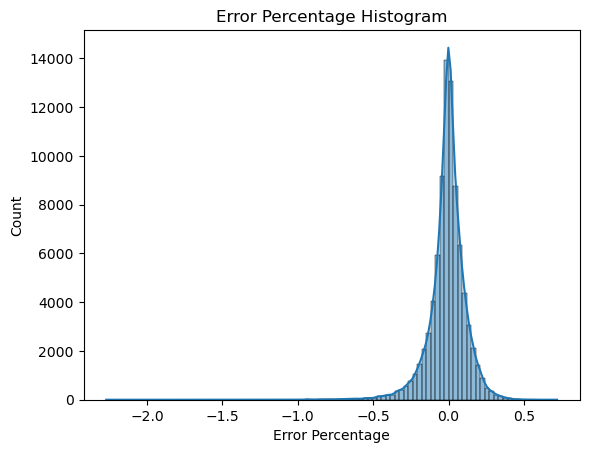

In [123]:
# histogram of errors
sns.histplot(
    X_test,
    x='error_perc',
    bins=100,
    kde=True
)
# addorn
plt.title("Error Percentage Histogram")
plt.xlabel("Error Percentage")
plt.ylabel("Count")
plt.show()

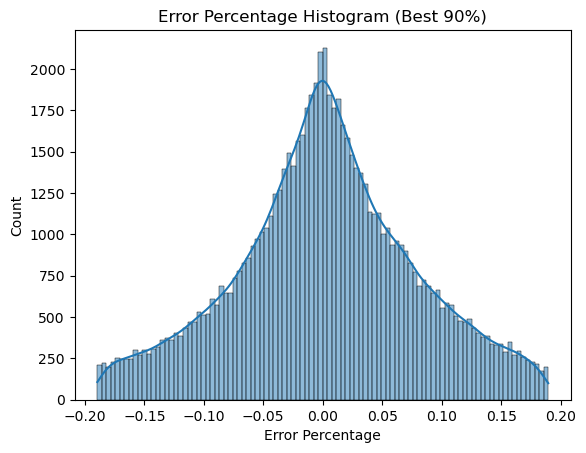

In [124]:
# best 90% histogram
sns.histplot(
    X_test[X_test['error_perc_abs'] <= X_test['error_perc_abs'].quantile(0.9)],
    x='error_perc',
    bins=100,
    kde=True
)
# addorn
plt.title("Error Percentage Histogram (Best 90%)")
plt.xlabel("Error Percentage")
plt.ylabel("Count")
plt.show()

### Categories

In [125]:
# errors for propertytype
(
    X_test
    .groupby('property_type', observed=True)
    .apply(lambda x: calculate_metrics(x['y_true'], x['y_pred'], best_percent=0.9), include_groups=False)
)

rmse      mape          mae        r2
property_type                                              
apartment      2204.663010  0.060714  1312.739398  0.975889
house          1085.644658  0.059714   775.274589  0.942225

In [126]:
# errors for propertytype
(
    X_test
    .groupby('cve_vigilancia_recat', observed=True)
    .apply(lambda x: calculate_metrics(x['y_true'], x['y_pred'], best_percent=0.9), include_groups=False)
)

rmse      mape          mae        r2
cve_vigilancia_recat                                              
0                     1297.838615  0.059766   829.905097  0.969173
1                     1867.970560  0.060820  1221.249565  0.971492

In [127]:
# errors for propertytype
(
    X_test
    .groupby('regimen_propiedad', observed=True)
    .apply(lambda x: calculate_metrics(x['y_true'], x['y_pred'], best_percent=0.9), include_groups=False)
)

rmse      mape          mae        r2
regimen_propiedad                                               
PRIVADA COLECTIVA   1647.684332  0.057798  1021.930064  0.976025
PRIVADA INDIVIDUAL  1068.178019  0.062308   760.876845  0.928362

In [128]:
# errors for state_id (only get mape)
table_errors_state = (
    X_test
    .groupby('state_id', observed=True)
    .apply(lambda x: calculate_metrics(x['y_true'], x['y_pred'], best_percent=0.9), include_groups=False)
)
table_errors_state

rmse      mape          mae        r2
state_id                                              
01             857.299435  0.053920   638.816003  0.924793
02            1313.030624  0.049534   906.201811  0.945875
03            1593.670175  0.069164  1121.958893  0.940554
04            1101.015391  0.080701   876.962433  0.861905
05             741.724614  0.055416   554.039756  0.911005
06            1018.150228  0.062089   752.564109  0.917256
07            1081.808217  0.069399   831.294029  0.748453
08             944.378803  0.059459   704.882701  0.911886
09            4924.628907  0.097967  3563.884526  0.908065
10             639.142117  0.053436   496.922307  0.898160
11             966.482631  0.058376   705.574349  0.923895
12            1837.236593  0.082906  1240.900830  0.941989
13             801.045321  0.050412   611.577989  0.921233
14            1473.231685  0.061295  1000.866118  0.962536
15            1469.638530  0.065358  1012.380656  0.952783
16            1091.298533  0.068918   819.529528  0.912450
17            1599.846280  0.069799  1153.557315  0.873152
18            1331.842564  0.064591   925.868186  0.951725
19             980.042703  0.048157   621.749535  0.973730
20            1118.819931  0.066206   883.216722  0.815876
21            1193.310258  0.064960   870.728389  0.915910
22            1270.530312  0.057203   965.246555  0.919258
23            1321.650178  0.045746   800.704902  0.975003
24            1035.756601  0.062819   786.284254  0.906111
25            1321.542046  0.066145   950.895118  0.944674
26             960.012526  0.059220   701.966974  0.939535
27            1173.200413  0.078115   909.828550  0.891956
28             632.235809  0.045248   457.773001  0.930120
29             708.234581  0.056141   523.848968  0.823683
30            1063.065324  0.070855   807.617010  0.863903
31             853.397519  0.047725   584.484320  0.954443
32             816.401885  0.053852   597.380027  0.891450

In [130]:
# see error upfront_beach of beach vs not infront of beach
(
    X_test
    .groupby('distance_to_ocean', observed=True)
    .apply(lambda x: calculate_metrics(x['y_true'], x['y_pred'], best_percent=0.9), include_groups=False)
)

rmse      mape          mae        r2
distance_to_ocean                                              
500.0              4721.302027  0.113454  2892.076854  0.916884
2000.0             2244.547731  0.085344  1458.796382  0.954116
10000.0            1171.792621  0.055746   805.850233  0.962183
50000.0             941.679323  0.055044   670.124750  0.943716
100000.0           1471.494387  0.060214   924.349314  0.973073

## Temporal Error

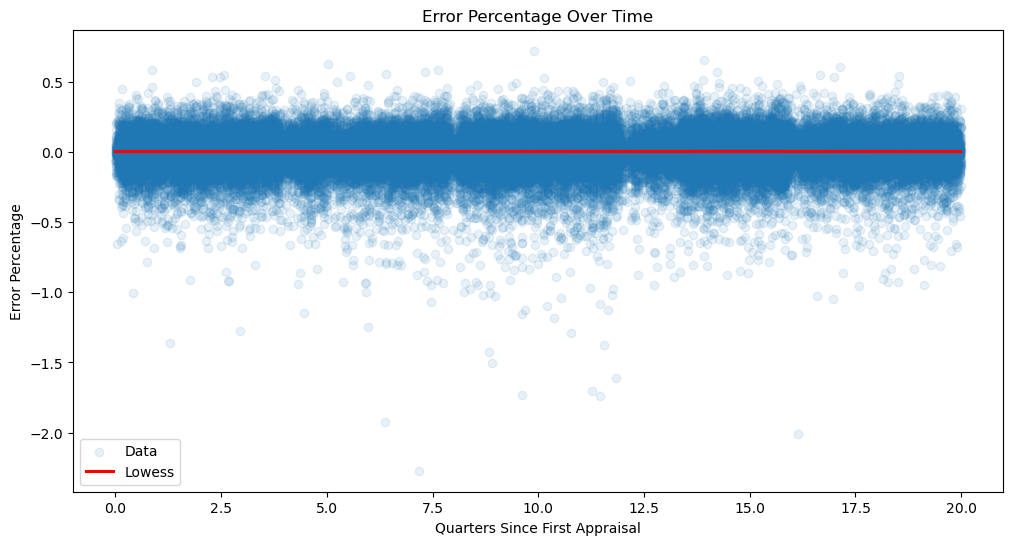

In [47]:
# visualize errors over time
fig, ax = plt.subplots(figsize=(12, 6))

sns.regplot(
    x='quarters_since_first_appraisal',
    y='error_perc',
    data=X_test,
    scatter_kws={'alpha': 0.1},
    line_kws={'color': 'red'},
    ax=ax,
    lowess=True
)

# addorn
plt.title("Error Percentage Over Time")
plt.xlabel("Quarters Since First Appraisal")
plt.ylabel("Error Percentage")

# add legend
plt.legend(['Data', 'Lowess'])

plt.show()

In [48]:
# adjust linear regression to error_perc
lm_time_error = smf.ols('error_perc ~ quarters_since_first_appraisal', data=X_test).fit()

# see summary
lm_time_error.summary()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             error_perc   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                 0.0004998
Date:                Sat, 21 Sep 2024   Prob (F-statistic):              0.982
Time:                        18:30:15   Log-Likelihood:                 57072.
No. Observations:               85292   AIC:                        -1.141e+05
Df Residuals:                   85290   BIC:                        -1.141e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         -0.0075      0.001     -9.019      0.000      -0.009      -0.006
quarters_since_first_appraisal  1.697e-06   7.59e-05      0.022      0.982      -0.000       0.000
==============================================================================
Omnibus:                    33964.176   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           505246.556
Skew:                          -1.514   Prob(JB):                         0.00
Kurtosis:                      14.533   Cond. No.                         21.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Geospatial Error

Text(0.5, 1.0, 'MAPE by state')

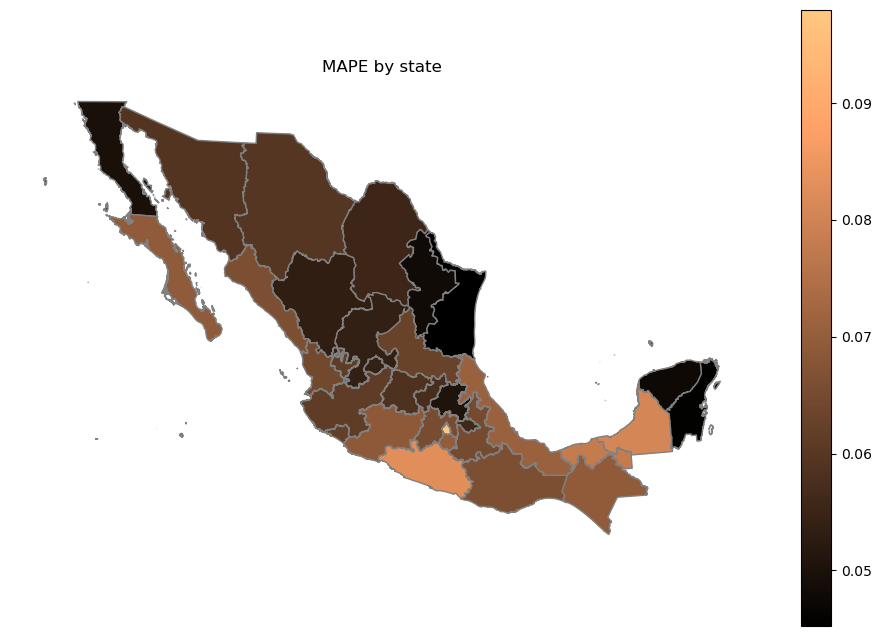

In [49]:
# plot MAPE by state
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

(
    gdf_mexico
    .merge(
        table_errors_state.reset_index(),
        left_on='cvegeo',
        right_on='state_id',
        how='left'
    )
    .plot('mape', legend=True, ax=ax, cmap='copper', edgecolor='gray')
)

# dont show axis
plt.axis('off')

# title
plt.title('MAPE by state')

## Covariates


In [50]:
def visualize_errors(df, col):
    # visualize errors over time
    fig, ax = plt.subplots(figsize=(12, 6))

    sns.regplot(
        x=col,
        y='error_perc',
        data=df,
        scatter_kws={'alpha': 0.1},
        line_kws={'color': 'red'},
        ax=ax,
        lowess=True
    )

    # addorn
    plt.title(f"Error Percentage by {col}")
    plt.xlabel(col)
    plt.ylabel("Error Percentage")

    # add legend
    plt.legend(['Data', 'Lowess'])

    plt.show()
    return

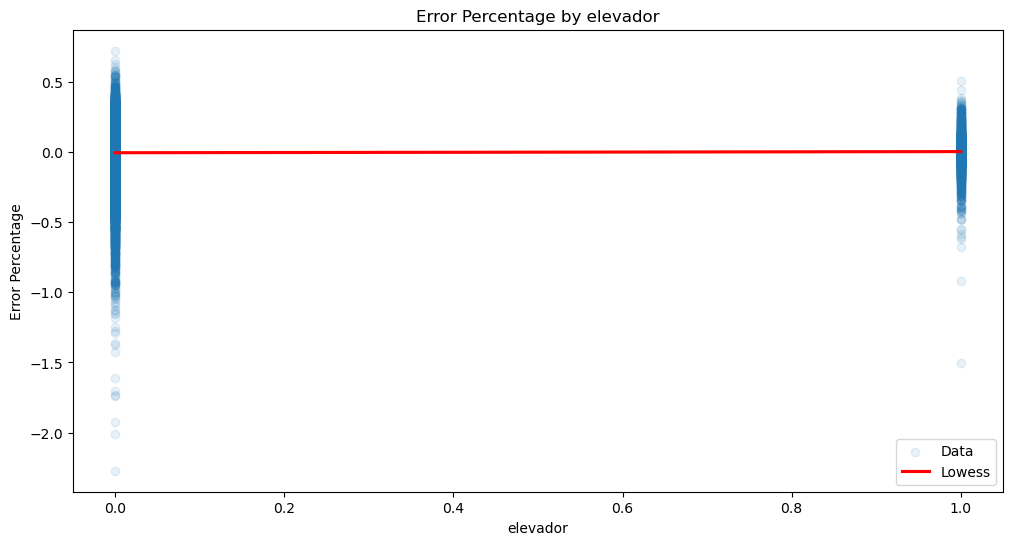

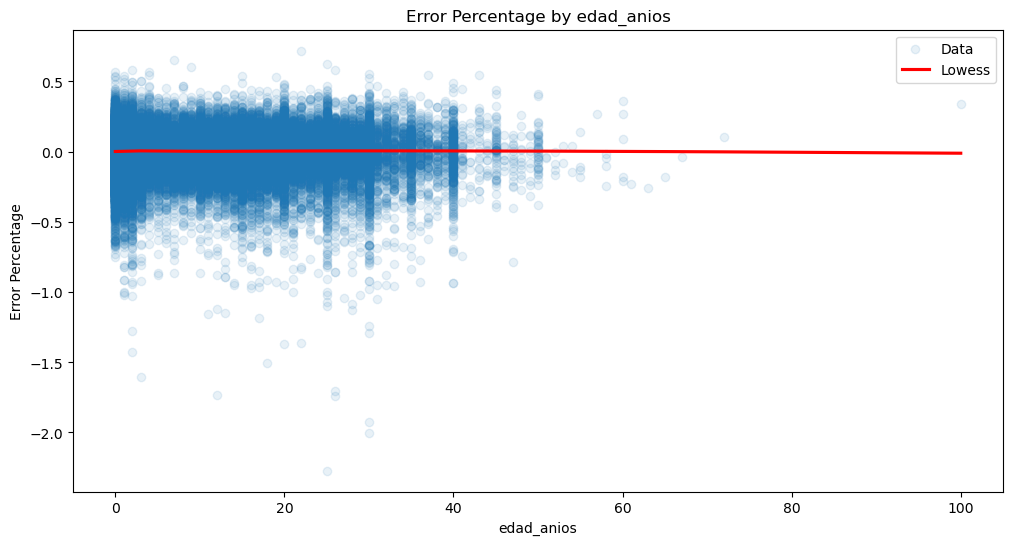

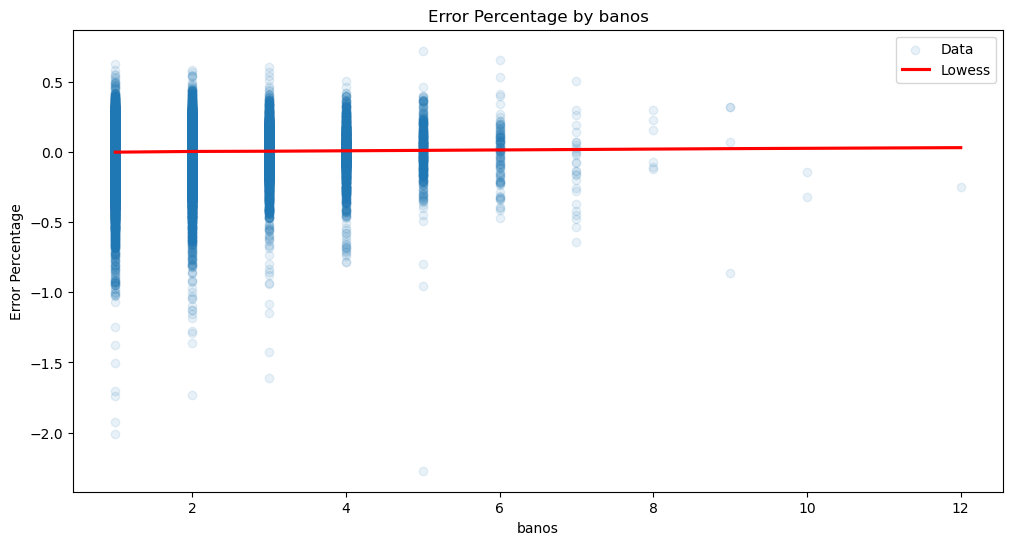

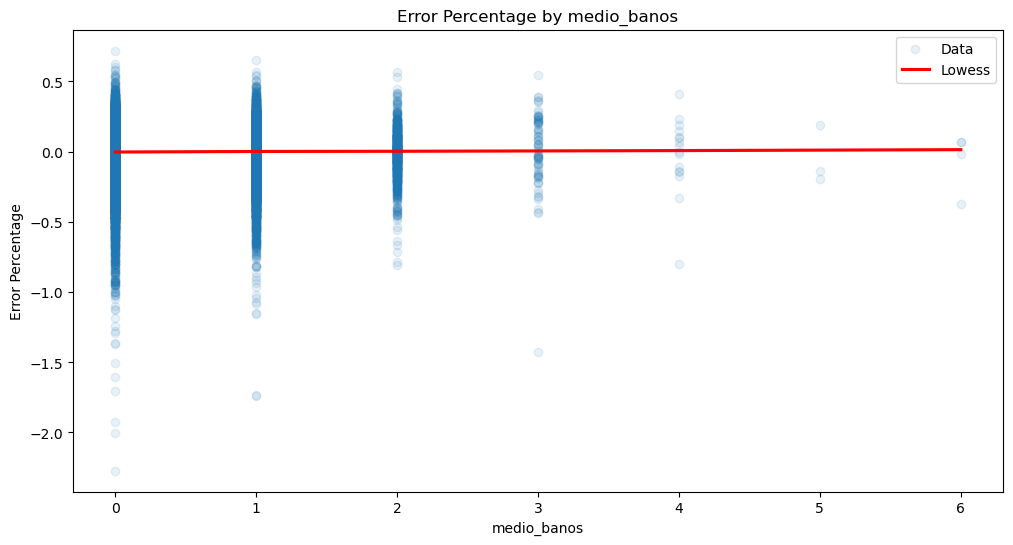

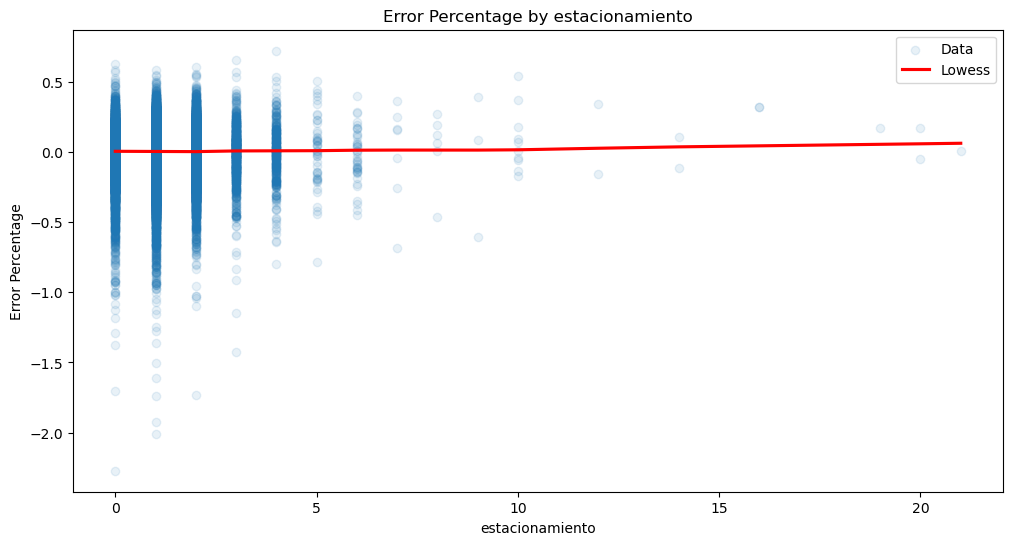

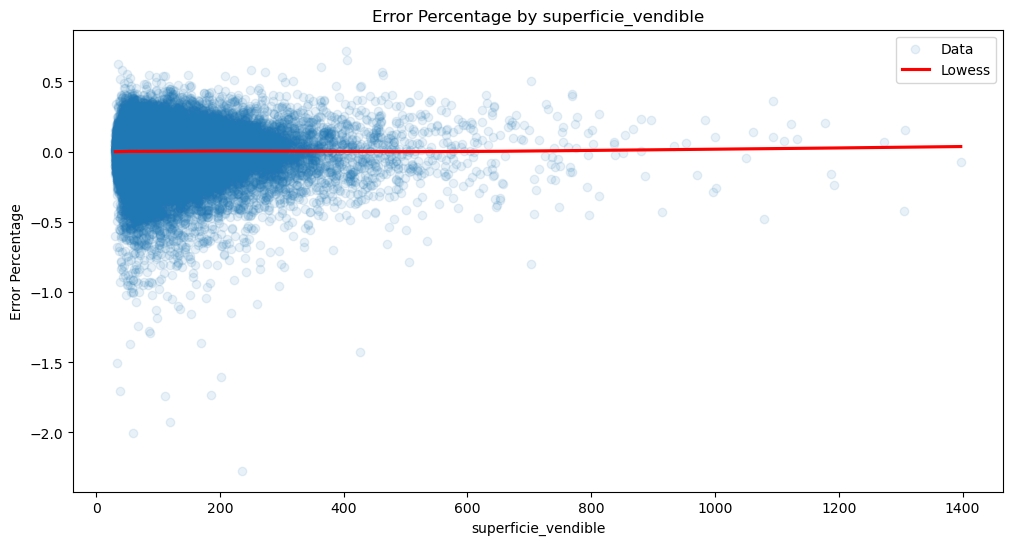

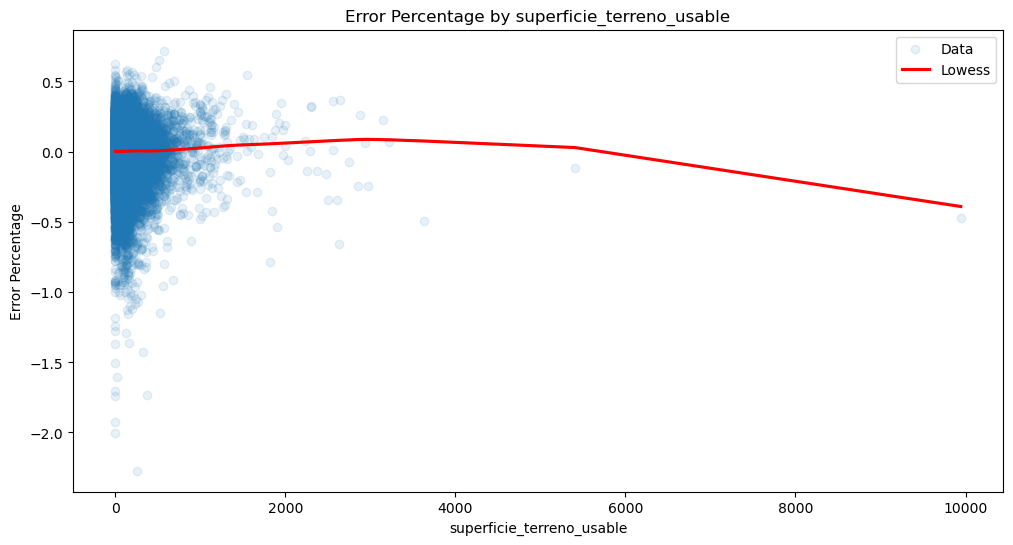

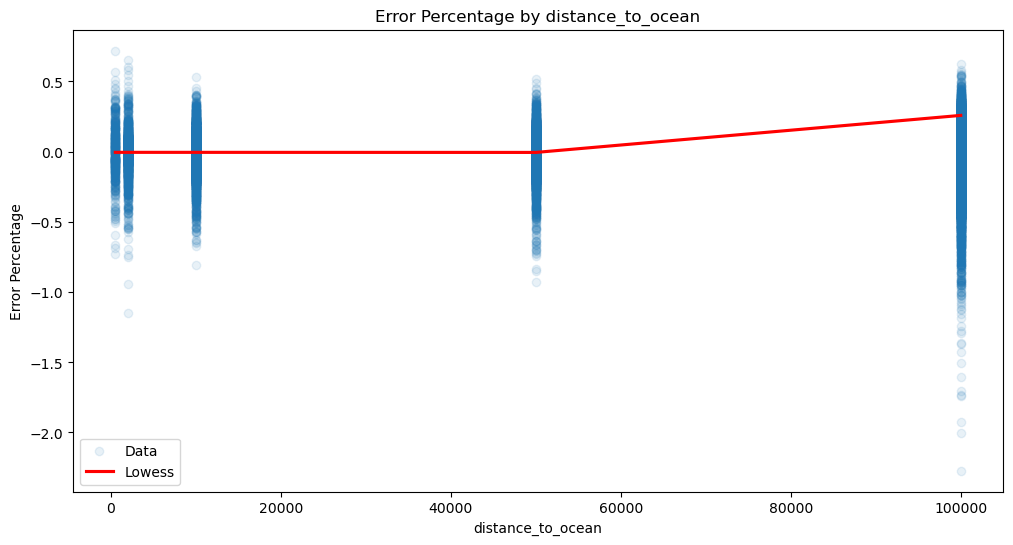

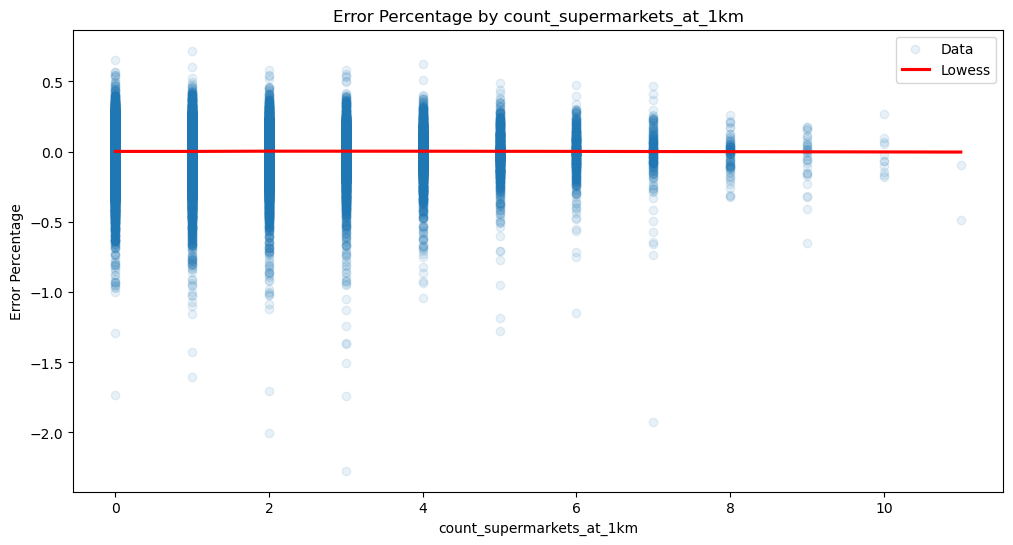

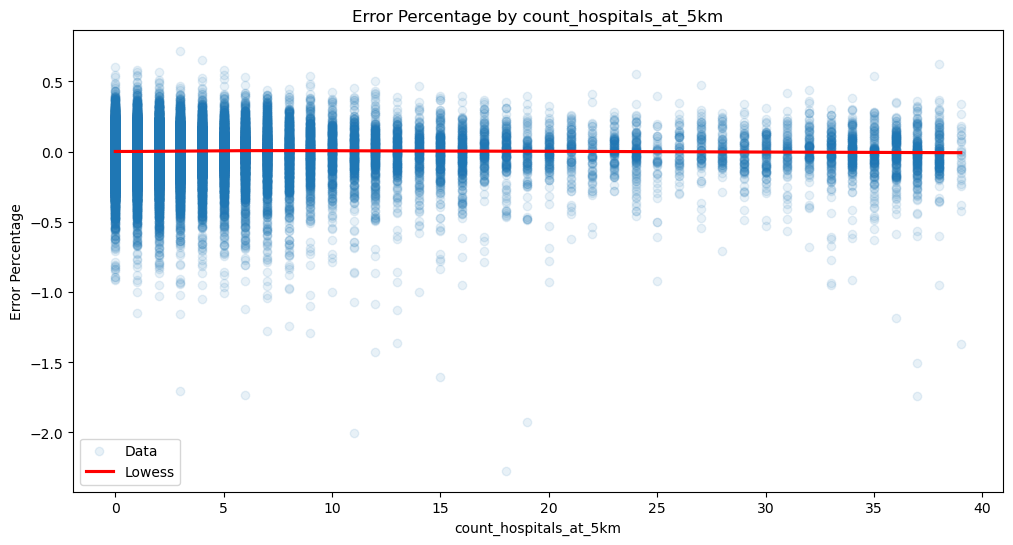

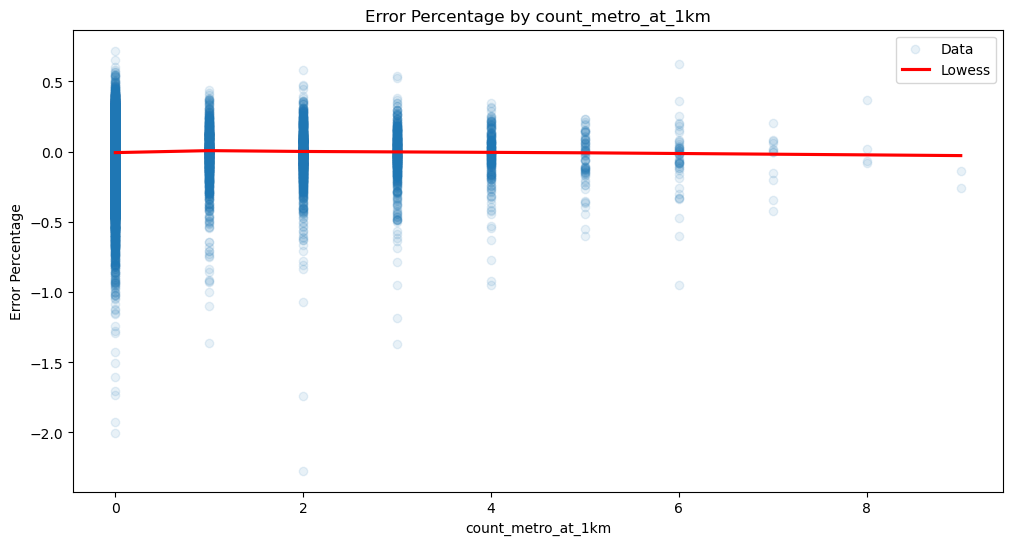

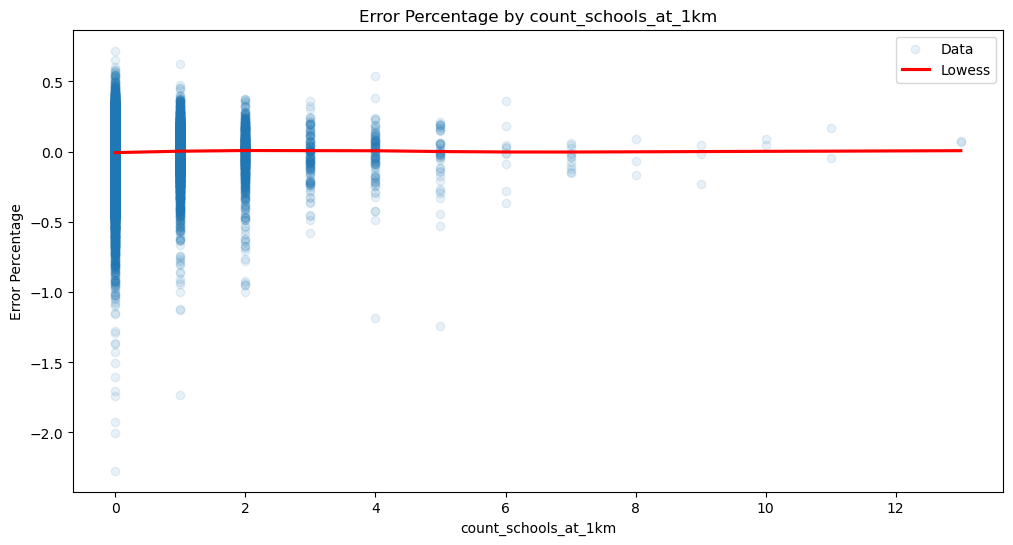

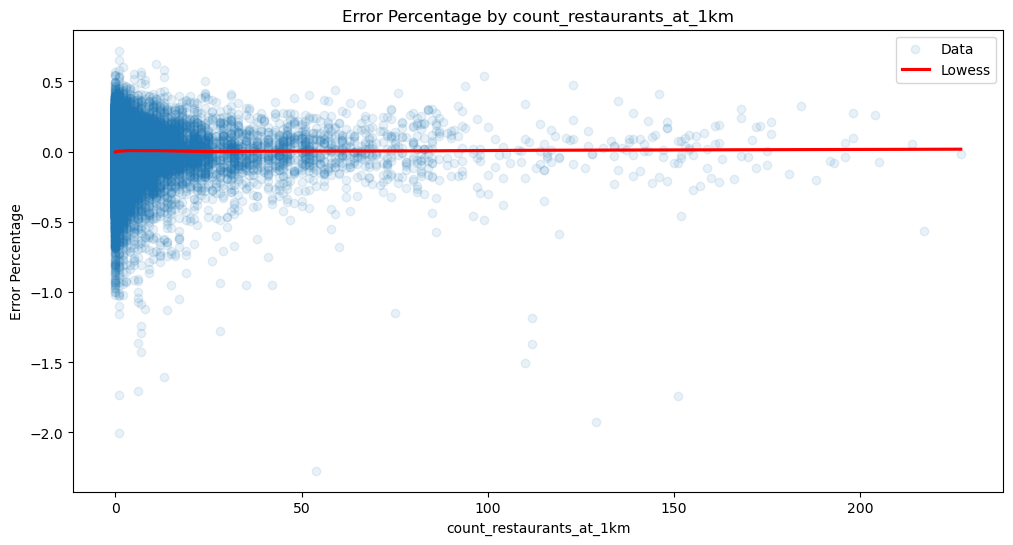

In [52]:
# visualize errors by categories
cols_x = [
    'elevador',
    'edad_anios',
    'banos',
    'medio_banos',
    'estacionamiento',
    'superficie_vendible',
    'superficie_terreno_usable',
    'distance_to_ocean',
    'count_supermarkets_at_1km',
    'count_hospitals_at_5km',
    'count_metro_at_1km',
    'count_schools_at_1km',
    'count_restaurants_at_1km',
    # 'competitors_weighted_mean_log_price_per_sqm',
    # 'mean_log_valor_fisico_terreno_m2',
    # 'mean_log_valor_fisico_terreno_m2_lower',
    # 'mean_log_valor_fisico_terreno_m2_upper',
    # 'quarters_since_first_appraisal', 
    # 'cve_vigilancia_recat'
]

for col in cols_x:
    visualize_errors(X_test, col)

## Time Series in special zones

Zones of interest:
- Andares, Guadalajara 8849ab4b45fffff
- Ruben Darío, Mexico City 884995bae9fffff
- Roma Norte, Mexico City 884995ba3dfffff
- Centrito Valle, Monterrey 8848a20667fffff
- Puerto Cancún, Cancún 884519b491fffff

The counterfactual will be the same property in different zones during the same period.


The property will be:
- id_clase_inmueble: 4 (media residencial)
- property_type: apartment
- elevador: 1
- edad_anios: 0 (new)
- regimen_propiedad: PRIVADA COLECTIVA
- state_id: (depends on the hex)
- banos: 2
- medio_banos: 1
- estacionamiento: 2
- superficie_vendible: 100
- superficie_terreno_usable: 100
- distance_to_ocean: 100000
- longitude: (depends on the hex)
- latitude: (depends on the hex)
- count_supermarkets_at_1km: 1
- count_hospitals_at_5km: 1
- count_metro_at_1km: 1
- count_schools_at_1km: 1
- count_restaurants_at_1km: 1
- competitors_weighted_mean_log_price_per_sqm: (depends on the hex)
- mean_log_valor_fisico_terreno_m2: (depends on the hex)
- mean_log_valor_fisico_terreno_m2_lower: (depends on the hex)
- mean_log_valor_fisico_terreno_m2_upper: (depends on the hex)
- quarters_since_first_appraisal: (time series)
- conservacion_recat: 3
- cve_vigilancia_recat: 1

In [270]:
def generate_counterfactual_property(h_id, df):
    """
    Generate a counterfactual property based on a given hex id.
    The property should have:

    - id_clase_inmueble: 4
    - property_type: 'apartment'
    - elevador: 1
    - edad_anios: 0
    - regimen_propiedad: 'PRIVADA COLECTIVA'
    - state_id: based on the hex_id
    - banos: 2
    - medio_banos: 1
    - estacionamiento: 1
    - superficie_vendible: 100
    - superficie_terreno_usable: 100
    - distance_to_ocean: 100_000
    - longitude: based on the hex_id
    - latitude: based on the hex_id
    - count_supermarkets_at_1km: 1
    - count_hospitals_at_5km: 1
    - count_metro_at_1km: 0
    - count_schools_at_1km: 1
    - count_restaurants_at_1km: 1
    - competitors_weighted_mean_log_price_per_sqm: based on the hex_id and quarter (doing a regression)
    - mean_log_valor_fisico_terreno_m2: based on the hex_id
    - mean_log_valor_fisico_terreno_m2_lower: based on the hex_id
    - mean_log_valor_fisico_terreno_m2_upper: based on the hex_id
    - quarters_since_first_appraisal: (time range from 0 to 20)
    - conservacion_recat: 3
    - cve_vigilancia_recat: 1
    """
    # Step 0: generate Series with fixed values
    s = pd.Series({
        'id_clase_inmueble': 6,
        'property_type': 'apartment',
        'elevador': 1,
        'edad_anios': 0,
        'regimen_propiedad': 'PRIVADA COLECTIVA',
        'banos': 1,
        'medio_banos': 1,
        'estacionamiento': 1,
        'superficie_vendible': 60,
        'superficie_terreno_usable': 60,
        'distance_to_ocean': 100_000,
        'count_supermarkets_at_1km': 1,
        'count_hospitals_at_5km': 1,
        'count_metro_at_1km': 0,
        'count_schools_at_1km': 1,
        'count_restaurants_at_1km': 1,
        'conservacion_recat': 3,
        'cve_vigilancia_recat': 1
    })

    # Step 1: get hex_id info
    # get hex_id info
    df = (
        df.copy()
        .query('hex_id == @h_id')
    )
    # get lat and long using h3_to_geo
    s['longitude'], s['latitude'] = h3.h3_to_geo(h_id)
    # get state_id
    s['state_id'] = df['state_id'].values[0]
    # get mean_log_valor_fisico_terreno_m2
    s['mean_log_valor_fisico_terreno_m2'] = df['mean_log_valor_fisico_terreno_m2'].apply(hmean).values[0]
    s['mean_log_valor_fisico_terreno_m2_lower'] = df['mean_log_valor_fisico_terreno_m2_lower'].apply(hmean).values[0]
    s['mean_log_valor_fisico_terreno_m2_upper'] = df['mean_log_valor_fisico_terreno_m2_upper'].apply(hmean).values[0]

    # Step 2: generate 20 counterfactuals but changing the quarters_since_first_appraisal from 0 to 20
    counterfactuals = []
    for i in range(21):
        s['quarters_since_first_appraisal'] = i
        counterfactuals.append(s.copy())
    
    # generate df
    df_counterfactuals = pd.DataFrame(counterfactuals)

    # Step 3: get competitors_weighted_mean_log_price_per_sqm
    # adjust a linear regression model
    x_variables = [
        # 'banos',
        # 'estacionamiento',
        'superficie_vendible',
        'quarters_since_first_appraisal'
    ]
    # x & y
    X = df.copy()[x_variables]
    y = np.log(df['price_per_sqm'])

    # fit
    lm = LinearRegression()
    lm.fit(X, y)
    # predict in counterfactuals
    x_counterfactuals = df_counterfactuals[x_variables].copy()
    # look beta of quarters_since_first_appraisal, if it is negative, then only predict for the quarter 10
    if lm.coef_[-1] < 0:
        x_counterfactuals['quarters_since_first_appraisal'] = 10
        df_counterfactuals['competitors_weighted_mean_log_price_per_sqm'] = lm.predict(x_counterfactuals[X.columns])
    else:
        df_counterfactuals['competitors_weighted_mean_log_price_per_sqm'] = lm.predict(x_counterfactuals)
    
    # see betas
    print(dict(zip(x_variables, lm.coef_)))

    return df_counterfactuals

# generate counterfactuals for 5 hex_ids
hex_ids_counterfactuals = [
    '8849ab4b45fffff',
    # '884995bae9fffff',
    '884995ba27fffff',
    '884995ba3dfffff',
    '8848a20667fffff',
    '884519b491fffff'
]

# counterfactuals, append the hex_id as index
X_counterfactuals = pd.concat(
    [generate_counterfactual_property(h_id, df_properties) for h_id in hex_ids_counterfactuals],
    keys=hex_ids_counterfactuals
)

# predict price per sqm
X_counterfactuals['price_per_sqm_pred'] = best_model.predict(Pool(X_counterfactuals, cat_features=categorical_cols))

# plot price per sqm pred vs quarters_since_first_appraisal for each hex_id
X_counterfactuals = X_counterfactuals.reset_index().rename(columns={'level_0': 'hex_id'})

# map hex_id to name
dict_hex_id_to_name = {
    '8849ab4b45fffff': 'andares-gdl',
    # '884995bae9fffff': 'ruben-dario-cdmx',
    '884995ba3dfffff': 'roma-norte-cdmx',
    '884995ba27fffff': 'doctores-cdmx',
    '8848a20667fffff': 'centrito-valle-mty',
    '884519b491fffff': 'pto-cancun-cancun'
}
X_counterfactuals['zone'] = X_counterfactuals['hex_id'].map(dict_hex_id_to_name)


{'superficie_vendible': -0.001225508326922126, 'quarters_since_first_appraisal': 0.02819912803050784}
{'superficie_vendible': 0.0025384512261379588, 'quarters_since_first_appraisal': 0.016368504786518467}
{'superficie_vendible': 0.001250615992823198, 'quarters_since_first_appraisal': 0.02336370478090729}
{'superficie_vendible': 0.0002425332863185972, 'quarters_since_first_appraisal': 0.018895553967706893}
{'superficie_vendible': -0.0004864014512227229, 'quarters_since_first_appraisal': 0.03502685354229646}


In [271]:
from pandas.tseries.offsets import QuarterEnd

# get first day of the minimum date
first_date_obs = df_properties['valuation_date'].min().to_period('Q').to_timestamp()

# create a column of the date of the appraisal using first_date_obs + quarters_since_first_appraisal
X_counterfactuals['date'] = X_counterfactuals['quarters_since_first_appraisal'].apply(
    lambda x: first_date_obs + QuarterEnd(x)
)

# see
X_counterfactuals.head()

hex_id  level_1  id_clase_inmueble property_type  elevador  \
0  8849ab4b45fffff        0                  6     apartment         1   
1  8849ab4b45fffff        1                  6     apartment         1   
2  8849ab4b45fffff        2                  6     apartment         1   
3  8849ab4b45fffff        3                  6     apartment         1   
4  8849ab4b45fffff        4                  6     apartment         1   

   edad_anios  regimen_propiedad  banos  medio_banos  estacionamiento  \
0           0  PRIVADA COLECTIVA      1            1                1   
1           0  PRIVADA COLECTIVA      1            1                1   
2           0  PRIVADA COLECTIVA      1            1                1   
3           0  PRIVADA COLECTIVA      1            1                1   
4           0  PRIVADA COLECTIVA      1            1                1   

   superficie_vendible  superficie_terreno_usable  distance_to_ocean  \
0                   60                         60             100000   
1                   60                         60             100000   
2                   60                         60             100000   
3                   60                         60             100000   
4                   60                         60             100000   

   count_supermarkets_at_1km  count_hospitals_at_5km  count_metro_at_1km  \
0                          1                       1                   0   
1                          1                       1                   0   
2                          1                       1                   0   
3                          1                       1                   0   
4                          1                       1                   0   

   count_schools_at_1km  count_restaurants_at_1km  conservacion_recat  \
0                     1                         1                   3   
1                     1                         1                   3   
2                     1                         1                   3   
3                     1                         1                   3   
4                     1                         1                   3   

   cve_vigilancia_recat   longitude     latitude state_id  \
0                     1  20.710139 -103.409833           14   
1                     1  20.710139 -103.409833           14   
2                     1  20.710139 -103.409833           14   
3                     1  20.710139 -103.409833           14   
4                     1  20.710139 -103.409833           14   

   mean_log_valor_fisico_terreno_m2  mean_log_valor_fisico_terreno_m2_lower  \
0                          9.935224                                9.281454   
1                          9.935224                                9.281454   
2                          9.935224                                9.281454   
3                          9.935224                                9.281454   
4                          9.935224                                9.281454   

   mean_log_valor_fisico_terreno_m2_upper  quarters_since_first_appraisal  \
0                               10.588994                               0   
1                               10.588994                               1   
2                               10.588994                               2   
3                               10.588994                               3   
4                               10.588994                               4   

   competitors_weighted_mean_log_price_per_sqm  price_per_sqm_pred  \
0                                    10.862904        41978.766737   
1                                    10.891104        41986.959428   
2                                    10.919303        41886.474376   
3                                    10.947502        42089.437447   
4                                    10.975701        43027.688066   

          zone       date  
0  andares-gdl 2019-03-31  
1  anda

/Users/ravj/opt/anaconda3/envs/mds-research-stay/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/ravj/opt/anaconda3/envs/mds-research-stay/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/ravj/opt/anaconda3/envs/mds-research-stay/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset =

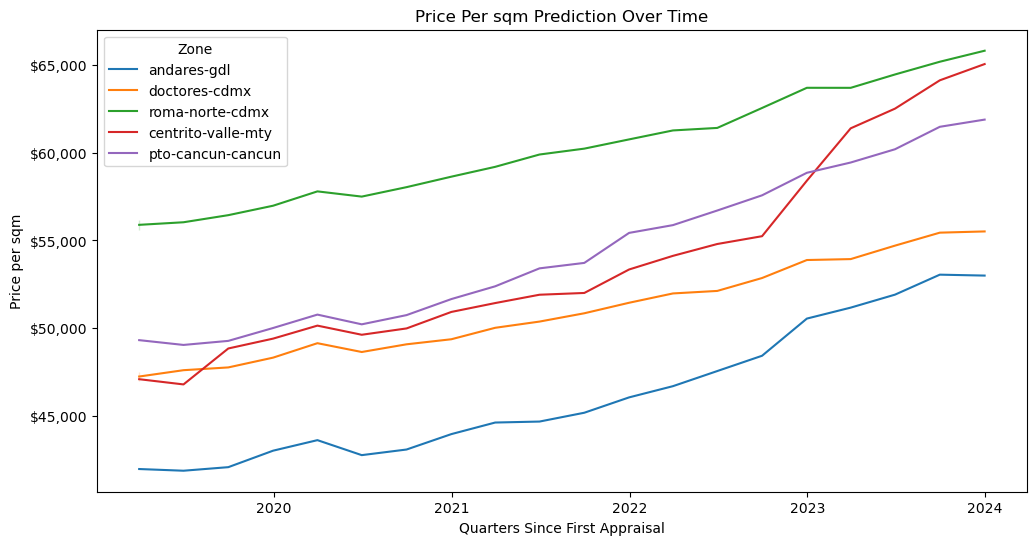

In [272]:
# plot
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(
    x='date',
    y='price_per_sqm_pred',
    hue='zone',
    data=X_counterfactuals,
    ax=ax
)

# y ticks as money
from matplotlib.ticker import FuncFormatter
def money_fmt(x, pos):
    return f"${x:,.0f}"

formatter = FuncFormatter(money_fmt)
ax.yaxis.set_major_formatter(formatter)

# every quarter add a tick
# import matplotlib.dates as mdates
# ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))



# addorn
plt.title("Price Per sqm Prediction Over Time")
plt.xlabel("Quarters Since First Appraisal")
plt.ylabel("Price per sqm")
plt.legend(title='Zone')

plt.show()



In [273]:
# fit a cuadratic model to the data
lm_appraisal_time = smf.ols(
    formula="price_per_sqm_pred ~ quarters_since_first_appraisal*zone",
    data=X_counterfactuals
).fit()

# see summary
lm_appraisal_time.summary()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     price_per_sqm_pred   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     348.9
Date:                Sun, 22 Sep 2024   Prob (F-statistic):           1.12e-68
Time:                        16:36:56   Log-Likelihood:                -878.38
No. Observations:                 105   AIC:                             1777.
Df Residuals:                      95   BIC:                             1803.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=============================================================================================================================
                                                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
Intercept                                                  4.013e+04    460.429     87.147      0.000    3.92e+04     4.1e+04
zone[T.centrito-valle-mty]                                 4788.8139    651.144      7.354      0.000    3496.129    6081.499
zone[T.doctores-cdmx]                                      6349.6270    651.144      9.751      0.000    5056.942    7642.312
zone[T.pto-cancun-cancun]                                  7119.7573    651.144     10.934      0.000    5827.072    8412.442
zone[T.roma-norte-cdmx]                                     1.48e+04    651.144     22.723      0.000    1.35e+04    1.61e+04
quarters_since_first_appraisal                              594.0937     39.385     15.084      0.000     515.905     672.283
quarters_since_first_appraisal:zone[T.centrito-valle-mty]   268.1231     55.699      4.814      0.000     157.547     378.699
quarters_since_first_appraisal:zone[T.doctores-cdmx]       -157.6869     55.699     -2.831      0.006    -268.263     -47.111
quarters_since_first_appraisal:zone[T.pto-cancun-cancun]     97.2273     55.699      1.746      0.084     -13.349     207.803
quarters_since_first_appraisal:zone[T.roma-norte-cdmx]      -80.1419     55.699     -1.439      0.153    -190.718      30.434
==============================================================================
Omnibus:                        1.887   Durbin-Watson:                   0.338
Prob(Omnibus):                  0.389   Jarque-Bera (JB):                1.326
Skew:                           0.198   Prob(JB):                        0.515
Kurtosis:                       3.382   Cond. No.                         132.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [300]:
# forest plot for the slopes
df_slopes = pd.DataFrame({
    'zone': lm_appraisal_time.params.index[lm_appraisal_time.params.index.str.contains('quarters_since_first_appraisal')],
    'slope': lm_appraisal_time.params[
        lm_appraisal_time.params.index.str.contains('quarters_since_first_appraisal')
    ].values,
    'ci_lower': lm_appraisal_time.conf_int().loc[
        lm_appraisal_time.params.index.str.contains('quarters_since_first_appraisal'), 0
    ].values,
    'ci_upper': lm_appraisal_time.conf_int().loc[
        lm_appraisal_time.params.index.str.contains('quarters_since_first_appraisal'), 1
    ].values
})

# clean zone string
df_slopes['zone'] = df_slopes['zone'].str.replace('quarters_since_first_appraisal', '')
df_slopes['zone'] = df_slopes['zone'].str.replace('zone[T.', '')
df_slopes['zone'] = df_slopes['zone'].str.replace(']', '')
df_slopes['zone'] = df_slopes['zone'].str.replace(':', '')

# if empty then andares-gdl
df_slopes['zone'] = df_slopes['zone'].replace('', 'andares-gdl')

# set as index
df_slopes = df_slopes.set_index('zone')

# for all zones except andares-gdl add andares-gdl value
df_slopes['slope'] = np.where(
    df_slopes.index == 'andares-gdl',
    df_slopes['slope'],
    df_slopes.loc['andares-gdl', 'slope'] + df_slopes['slope']
)
df_slopes['ci_lower'] = np.where(
    df_slopes.index == 'andares-gdl',
    df_slopes['ci_lower'],
    df_slopes.loc['andares-gdl', 'ci_lower'] + df_slopes['ci_lower']
)
df_slopes['ci_upper'] = np.where(
    df_slopes.index == 'andares-gdl',
    df_slopes['ci_upper'],
    df_slopes.loc['andares-gdl', 'ci_upper'] + df_slopes['ci_upper']
)

# sort by slope
df_slopes = df_slopes.sort_values('slope')

# see
df_slopes


slope    ci_lower     ci_upper
zone                                                   
doctores-cdmx       436.406839  247.641547   625.172131
roma-norte-cdmx     513.951834  325.186541   702.717126
andares-gdl         594.093738  515.904594   672.282882
pto-cancun-cancun   691.321012  502.555720   880.086304
centrito-valle-mty  862.216817  673.451525  1050.982110

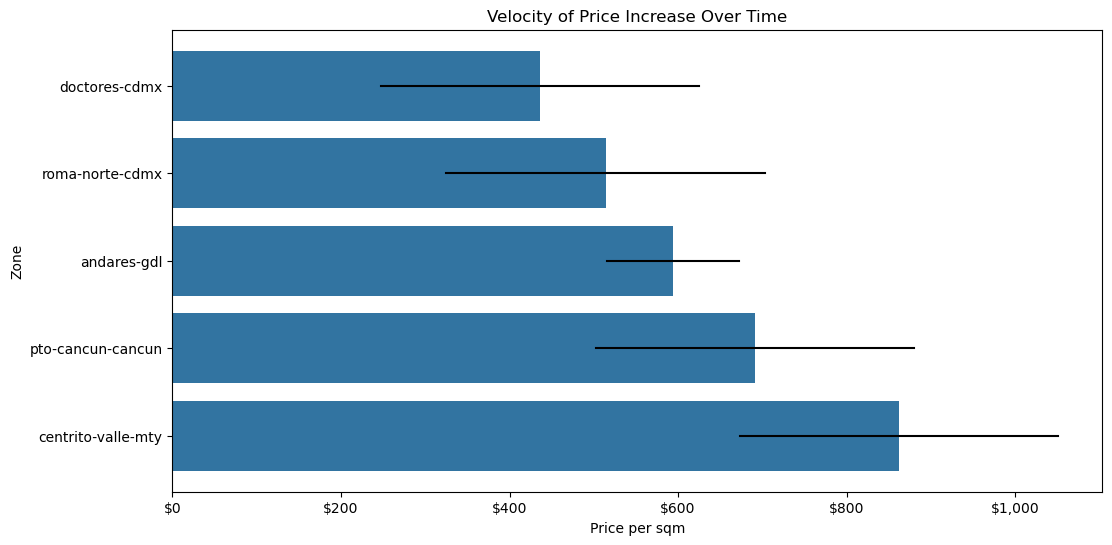

In [303]:
# forest plot
fig, ax = plt.subplots(figsize=(12, 6))

# plot
sns.barplot(
    x='slope',
    y='zone',
    data=df_slopes,
    ax=ax,
    orient='h'
)

# add confidence intervals
for i, row in df_slopes.iterrows():
    ax.plot(
        [row['ci_lower'], row['ci_upper']],
        [i, i],
        color='black'
    )

# addorn
plt.title("Velocity of Price Increase Over Time")
plt.xlabel("Price per sqm")
plt.ylabel("Zone")

# x ticks as money
from matplotlib.ticker import FuncFormatter
def money_fmt(x, pos):
    return f"${x:,.0f}"

formatter = FuncFormatter(money_fmt)
ax.xaxis.set_major_formatter(formatter)

# show
plt.show()


---
# Feature Importance

## General Importance

In [53]:
## Feature Importance
explainer = shap.TreeExplainer(best_model)

# calculate shap values
cols_x = [
    'id_clase_inmueble', 
    'property_type',
    'elevador', 'edad_anios',
    'regimen_propiedad', 'state_id', 'banos',
    'medio_banos', 'estacionamiento', 'superficie_vendible',
    'superficie_terreno_usable', 'distance_to_ocean', 'longitude', 'latitude',
    'count_supermarkets_at_1km', 'count_hospitals_at_5km',
    'count_metro_at_1km', 'count_schools_at_1km',
    'count_restaurants_at_1km',
    'competitors_weighted_mean_log_price_per_sqm',
    'mean_log_valor_fisico_terreno_m2',
    'mean_log_valor_fisico_terreno_m2_lower',
    'mean_log_valor_fisico_terreno_m2_upper',
    'quarters_since_first_appraisal', 'conservacion_recat',
    'cve_vigilancia_recat'
]
shap_values = explainer(X_test.loc[:, cols_x])

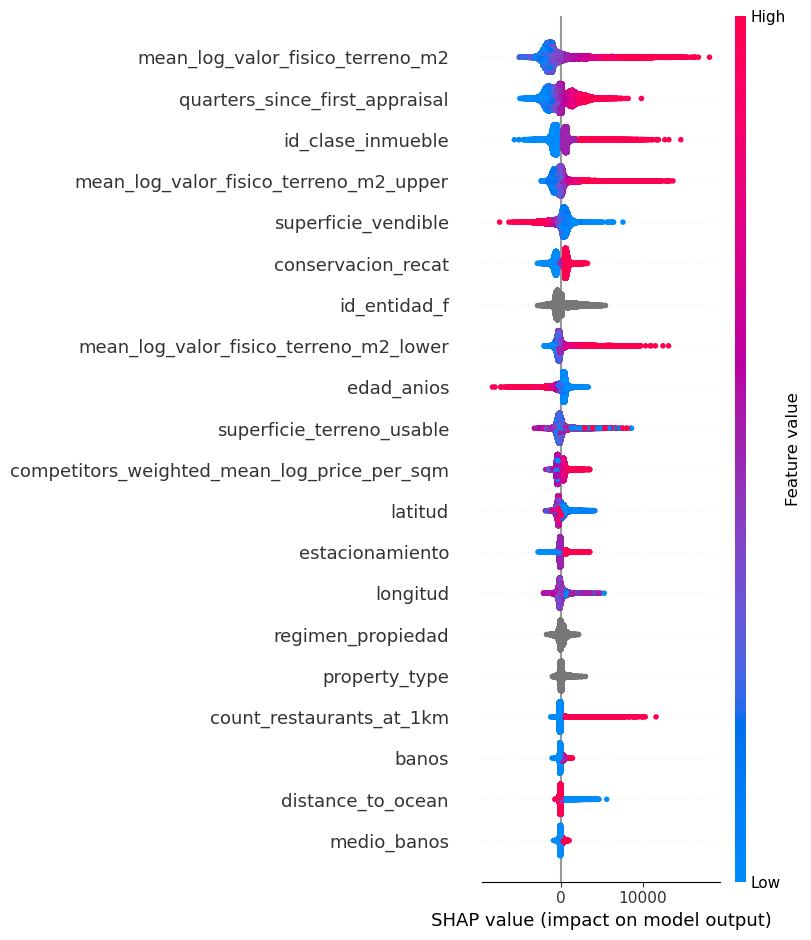

In [54]:
# plot feature importance
shap.summary_plot(shap_values, X_test.loc[:, cols_x])

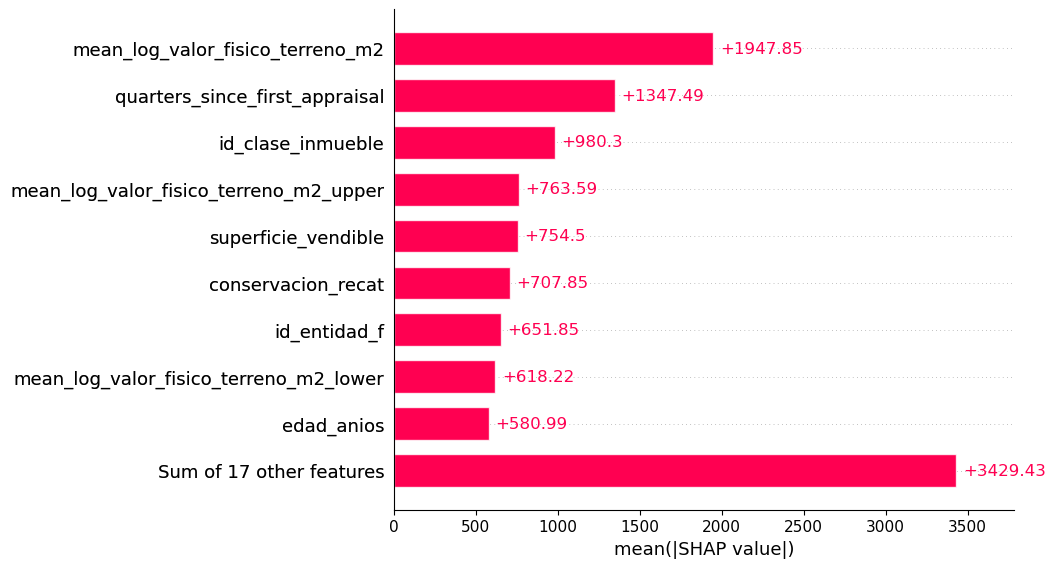

In [55]:
# plot feature importance
shap.plots.bar(shap_values, max_display=10)

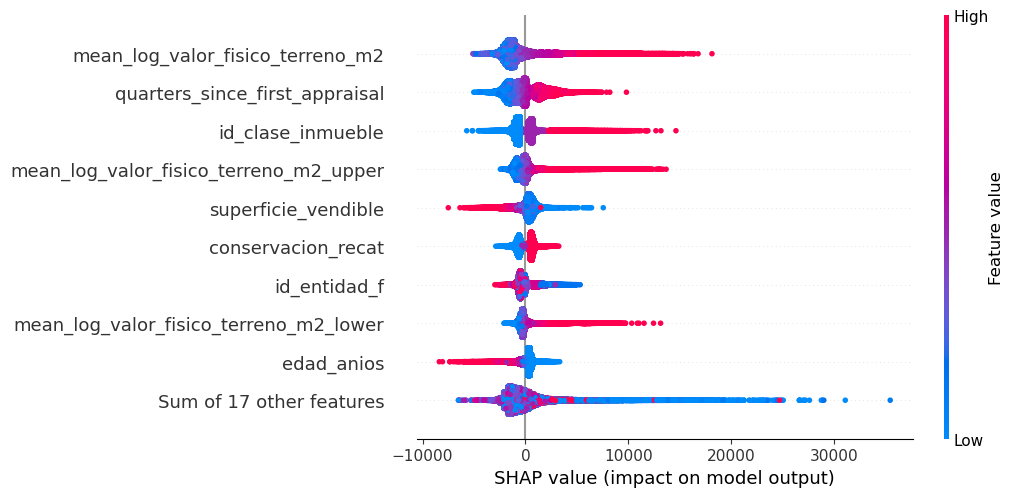

In [56]:
# Plot a beeswarm plot of SHAP values
shap.plots.beeswarm(shap_values, max_display=10)

## Interactions

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


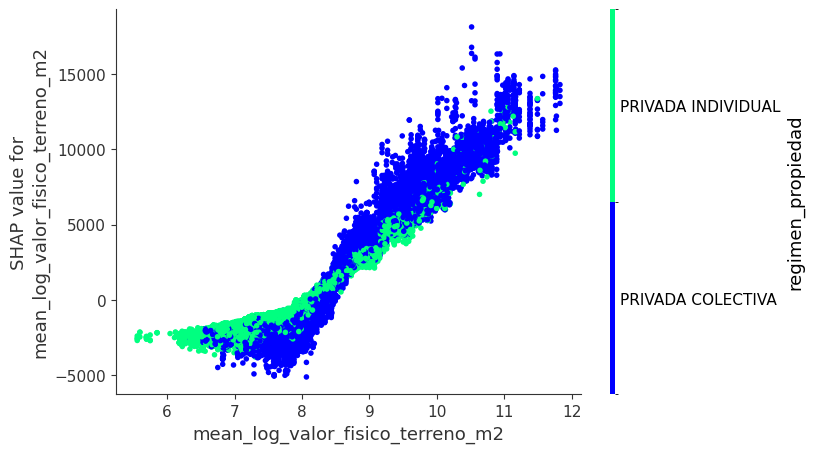

In [57]:
# partal dependence plot
shap.dependence_plot('mean_log_valor_fisico_terreno_m2', shap_values.values, X_test.loc[:, cols_x], cmap=plt.get_cmap("winter"))

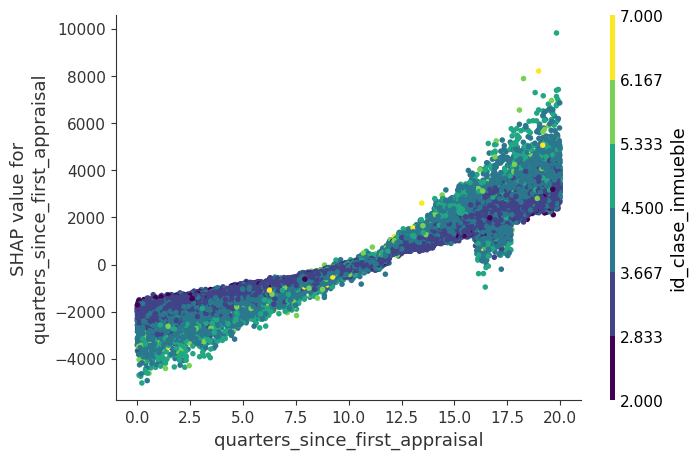

In [58]:
# partal dependence plot
shap.dependence_plot('quarters_since_first_appraisal', shap_values.values, X_test.loc[:, cols_x], interaction_index='id_clase_inmueble', cmap=plt.get_cmap("viridis"))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


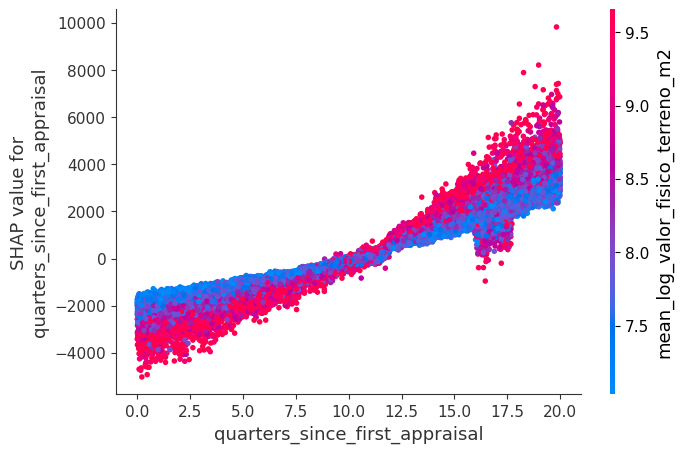

In [59]:
# partal dependence plot
shap.dependence_plot('quarters_since_first_appraisal', shap_values.values, X_test.loc[:, cols_x])

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


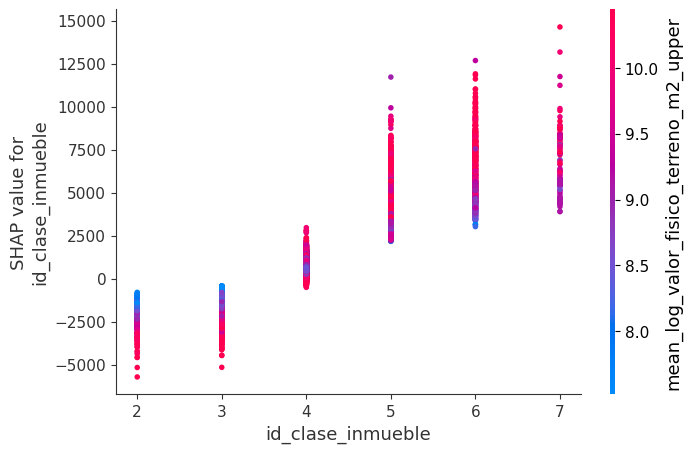

In [60]:
# partal dependence plot
shap.dependence_plot('id_clase_inmueble', shap_values.values, X_test.loc[:, cols_x])

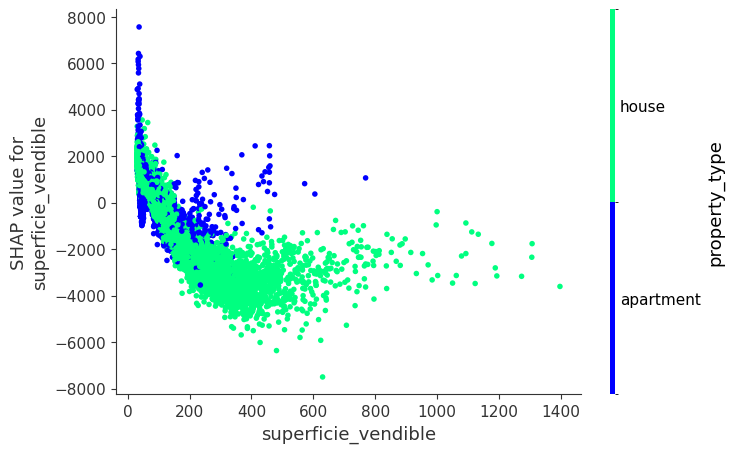

In [61]:
# partal dependence plot
shap.dependence_plot('superficie_vendible', shap_values.values, X_test.loc[:, cols_x], interaction_index='property_type', cmap=plt.get_cmap("winter"))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


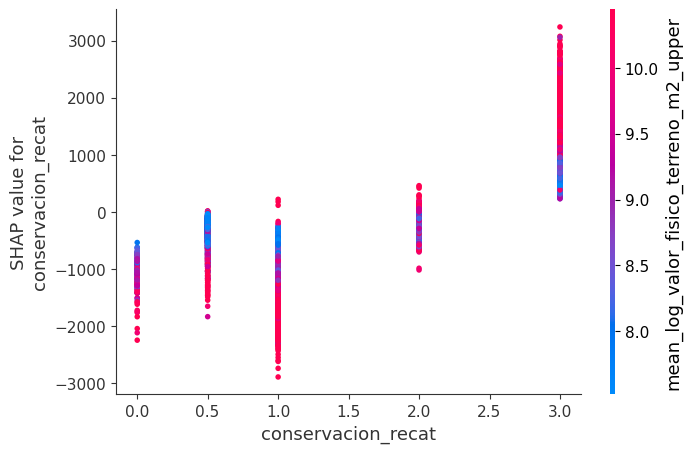

In [62]:
# partal dependence plot
shap.dependence_plot('conservacion_recat', shap_values.values, X_test.loc[:, cols_x])

^^^maybe my categorization of remodeled is not good (move 1 position more)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


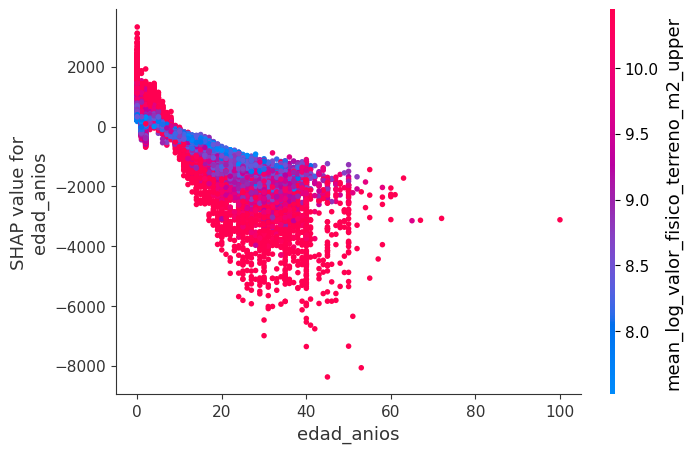

In [63]:
# partal dependence plot
shap.dependence_plot('edad_anios', shap_values.values, X_test.loc[:, cols_x])

---
# Sandbox

In [138]:
df_properties['property_type'].value_counts()

property_type
house        645566
apartment    207347
Name: count, dtype: int64

In [149]:
df_properties['cve_vigilancia_recat'].value_counts()

cve_vigilancia_recat
0    699415
1    153498
Name: count, dtype: int64

In [150]:
# calculate harmonic mean
(
    df_properties
    .groupby('cve_vigilancia_recat')
    .agg({'price_per_sqm': hmean})
    .sort_values('cve_vigilancia_recat', ascending=False)
)

/var/folders/42/2lkg1sf91wv7mjxw6klfcqtc0000gn/T/ipykernel_55876/2544819367.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('cve_vigilancia_recat')


price_per_sqm
cve_vigilancia_recat               
1                      15588.388494
0                      11341.762901

In [153]:
df_properties['quarters_since_first_appraisal'].describe()

count    852913.000000
mean          9.362340
std           5.598605
min           0.000000
25%           4.484649
50%           9.221491
75%          14.155702
max          20.010965
Name: quarters_since_first_appraisal, dtype: float64

In [233]:
df_properties.filter(like='fecha').describe()

valuation_date
count                         852913
mean   2021-05-03 20:17:26.748730624
min              2019-01-01 00:00:00
25%              2020-02-14 00:00:00
50%              2021-04-21 00:00:00
75%              2022-07-15 00:00:00
max              2023-12-31 00:00:00

In [ ]:
X_test.columns

Index(['id_clase_inmueble', 'property_type', 'elevador', 'edad_anios',
       'regimen_propiedad', 'state_id', 'banos', 'medio_banos',
       'estacionamiento', 'superficie_vendible', 'superficie_terreno_usable',
       'distance_to_ocean', 'longitude', 'latitude', 'count_supermarkets_at_1km',
       'count_hospitals_at_5km', 'count_metro_at_1km', 'count_schools_at_1km',
       'count_restaurants_at_1km',
       'competitors_weighted_mean_log_price_per_sqm',
       'mean_log_valor_fisico_terreno_m2',
       'mean_log_valor_fisico_terreno_m2_lower',
       'mean_log_valor_fisico_terreno_m2_upper',
       'quarters_since_first_appraisal', 'conservacion_recat',
       'cve_vigilancia_recat', 'y_pred', 'y_true', 'error', 'error_perc',
       'error_perc_abs'],
      dtype='object')

In [ ]:
df_properties.columns

Index(['id_clase_inmueble', 'property_type', 'elevador', 'edad_anios',
       'year_appraised', 'regimen_propiedad', 'state_id', 'banos',
       'medio_banos', 'estacionamiento', 'superficie_vendible',
       'superficie_terreno_usable', 'distance_to_ocean', 'longitude', 'latitude',
       'count_supermarkets_at_1km', 'count_hospitals_at_5km',
       'count_metro_at_1km', 'count_schools_at_1km',
       'count_restaurants_at_1km',
       'competitors_weighted_mean_log_price_per_sqm',
       'mean_log_valor_fisico_terreno_m2',
       'mean_log_valor_fisico_terreno_m2_lower',
       'mean_log_valor_fisico_terreno_m2_upper',
       'quarters_since_first_appraisal', 'conservacion_recat',
       'cve_vigilancia_recat', 'price_per_sqm'],
      dtype='object')